In [2]:
import sys
sys.path.append("..")

In [3]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

C:\Users\jw1301\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


current XLA device: cpu


In [4]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

Here we auto-download the E-OBS basin data, if necessary.

# Data

In [7]:
basin_id = 6340800
basin_info = pd.read_csv("../data/eobs-basins/basins_info.csv")
name_map = wx.data.data_var_name_map(prec="pre", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax")
basin_data_all = wx.data.load_time_series_csv("../data/eobs-basins/eobs_basins_averaged_all.csv", name_map)


In [8]:
basin_data = basin_data_all.loc[basin_data_all.id == basin_id].drop(columns=basin_data_all.columns[0])

In [9]:
basin_info[basin_info.id == basin_id]

,id,wmo_reg,sub_reg,river,station,country,lat,lon,area,altitude_station,...,r_volume_yr,r_height_yr,clay,sand,mineral_bulk_density,altitude_basin,forest,impervious,pervious,slope
531,6340800,6,6401,SPREE,SPREMBERG,DE,51.577,14.37,2092.0,91.52,...,0.505018,241.404161,0.142248,0.526502,0.012846,206.270072,0.386012,0.024523,0.589464,2.507489


In [9]:
# prec_summary_ref = basin_data_ref.pre.groupby(basin_data_ref.index.year).apply(
#     lambda x: pd.DataFrame(wx.utils.precip_summary_stats(jnp.array(x)).reshape((1,-1)), columns=["ptot", "p99", "pmean", "wd", "cdd"])
# ).reset_index().drop('level_1', axis=1).set_index('time')
# tair_summary_ref = basin_data_ref.tavg.groupby(basin_data_ref.index.year).apply(
#     lambda x: pd.DataFrame(wx.utils.tair_summary_stats(jnp.array(x)).reshape((1,-1)), columns=['T10','T50','T90','TDD','FDD'])
# ).reset_index().drop('level_1', axis=1).set_index('time')

In [20]:
nfreqs = 1 # 5

basin_data_train = basin_data["1950":"1980"] #1990
# Tair_freqs = np.array([1.0,2.0,5.0,10.0,20.0])/(365.25*10)
# prec_freqs = np.array([1.0,2.0,5.0,10.0,20.0])/(365.25*10)
Tair_freqs = wx.utils.truncated_fft(basin_data_train.Tair_mean.values, nfreqs=nfreqs)["freq"]
prec_freqs = wx.utils.truncated_fft(basin_data_train.prec.values, nfreqs=nfreqs)["freq"]

In [11]:
Tair_freqs = wx.utils.truncated_fft(basin_data_train.Tair_mean.values, nfreqs=3)["freq"][[0,2]]
1/Tair_freqs

0    365.258065
2    195.224138
Name: freq, dtype: float64

In [12]:
wx.utils.truncated_fft(basin_data_train.Tair_mean.values, nfreqs=5)

,amp,phase,freq,period
0,4.866335,-0.297876,0.002738,365.258065
1,0.313744,-1.433473,0.000353,2830.750000
2,0.278833,-0.184977,0.005122,195.224138
3,0.233496,-0.341956,0.015455,64.702857
4,0.207948,0.000577,0.005564,179.730159


In [494]:
wx.utils.truncated_fft((basin_data_trainn["Tair_max"] - basin_data_train["Tair_min"]).values, nfreqs=5)

,amp,phase,freq,period
0,1.527550,0.052074,0.002738,365.258065
1,0.315232,0.292261,0.005476,182.629032
2,0.170029,-0.736980,0.008213,121.752688
3,0.134941,-0.869768,0.001325,754.866667
4,0.122533,0.330654,0.004151,240.914894


In [495]:
wx.utils.truncated_fft((basin_data_train["Tair_max"]).values, nfreqs=5)

,amp,phase,freq,period
0,5.629358,-0.261179,0.002738,365.258065
1,0.321809,-1.510548,0.000353,2830.750000
2,0.290626,-0.291181,0.005122,195.224138
3,0.269853,0.212710,0.005476,182.629032
4,0.260983,-0.414808,0.015455,64.702857


In [497]:
wx.utils.truncated_fft((basin_data_train["Tair_mean"] ).values, nfreqs=5)

,amp,phase,freq,period
0,4.866335,-0.297876,0.002738,365.258065
1,0.313744,-1.433473,0.000353,2830.750000
2,0.278833,-0.184977,0.005122,195.224138
3,0.233496,-0.341956,0.015455,64.702857
4,0.207948,0.000577,0.005564,179.730159


# Model

In [509]:
from weathergen.wgen.wgen_glm_v5 import *

In [518]:
def wgen_glm_v5(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    Tavg_dof_mean=None,
    Tskew_scaled_dispersion_mean=1.0,
    Tair_freqs=[1 / 365.25],
    prec_freqs=[1 / 365.25],
    order=1,
    **kwargs,
):
    """Improved WGEN-GLM which generates daily weather variables according to the following procedure:
        1) Tavg(t) | Tavg(t-1), ...,Tavg(t-n)
        2) prec | prec(t-1), ..., prec(t-n), Tavg(t-1), ...,Tavg(t-n)
        3) Trange | prec, Tavg
        4) Tskew | prec, Tavg

        Mean daily air temperature is modelled as Student-T distribution with variable degrees of freedom.
        Precipitation is modelled as a bernoulli-Gamma mixture distribution.
        Daily air temperature range is modelled as a Gamma distribution.
        Daily air temperature skewness is modeled as a Beta distribution.

        Each of these observable variables are parameterized as GLMs defined over some set of linear predictors.

    Args:
        num_predictors (int, optional): number of exogeneous predictors. Defaults to 1.
        Tavg_dof_mean (float, optional): if not None, specifies the prior mean of the DoF parameter for a Student-t likelihood. Defaults to None, i.e. Gaussian likelihood.
        pred_effect_scale (float, optional): standard deviation of the predictor effect prior. Defaults to 1.0.
        Tskew_scaled_dispersion_mean (float, optional): prior mean of the Tskew dispersion parameter. Defaults to 1.0.
        Tair_freqs (list, optional): frequencies for air temperature seasonal effects. Defaults to the annual cycle: [1/365.25].
        prec_freqs (list, optional): frequencies for precipitation seasonal effects. Defaults to the annual cycle: [1/365.25].

    Returns:
        _type_: _description_
    """
    assert num_predictors > 0, "number of predictors must be greater than zero"

    # mean air temperature
    tair_mean_step = wgen_glm_v5_Tair_mean(
        num_predictors,
        pred_effect_scale,
        Tavg_dof_mean,
        freqs=Tair_freqs,
        order=order,
        **kwargs,
    )
    # precipitation
    precip_step = wgen_glm_v5_precip(num_predictors, pred_effect_scale, freqs=prec_freqs, order=order, **kwargs)
    # air temperature range and skew
    tair_range_skew_step = wgen_glm_v5_Tair_range_skew(
        num_predictors,
        pred_effect_scale,
        Tskew_scaled_dispersion_mean,
        freqs=Tair_freqs,
        order=order,
        **kwargs,
    )

    def step(state, inputs, obs={"prec": None, "Tavg": None, "Trange": None, "Tskew": None}):
        assert state.shape[0] == inputs.shape[0], "state and input batch dimensions do not match"
        assert state.shape[1] == order, f"state lag dimension does not match order={order}"
        # unpack state and input tensors;
        # state is assumed to have shape (batch, lag, vars)
        prec_prev = state[:, :, 0]
        Tavg_prev = state[:, :, 1]
        Trange_prev = state[:, :, 2]
        # i, year, month, doy = inputs[:, :4].T
        # predictors = inputs[:, 4:]
        # mean daily air temperature
        Tavg, Tavg_mean, Tavg_mean_seasonal = tair_mean_step(Tavg_prev, inputs, obs["Tavg"])
        Tavg_anom = (Tavg - Tavg_mean_seasonal).reshape((-1, 1))
        # precipitation
        prec = precip_step((prec_prev, Tavg_anom), inputs, obs["prec"])
        # air temperature range and skew
        Trange, Tskew, Tmin, Tmax = tair_range_skew_step((Tavg, prec, Trange_prev), inputs, obs["Trange"], obs["Tskew"])
        newstate = jnp.expand_dims(jnp.stack([prec, Tavg, Trange]).T, axis=1)
        return jnp.concat([state[:, 1:, :], newstate], axis=1), (prec, Tmin, Tavg, Tmax)

    return step


In [520]:


def wgen_glm_v5_Tair_mean(
    num_predictors: int = 1,
    pred_effect_scale=jnp.ones(1),
    Tavg_dof_mean=None,
    freqs=[1 / 365.25],
    order=1,
    **kwargs,
):
    ## autocorrelation for air temperature is bounded from [-1,1] to prevent divergence
    Tavg_lag_effects = numpyro.sample("Tavg_lag", dist.MultivariateNormal(jnp.zeros(order), 0.2 * jnp.eye(order)))
    ## fourier feature coefficients (seasonal effects)
    seasonal_dims = 2 * len(freqs)
    Tavg_seasonal_effects = numpyro.sample(
        "Tavg_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_seasonal_lag1_effects = numpyro.sample(
        "Tavg_seasonal&lag1",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    Tavg_pred_effects = numpyro.sample(
        "Tavg_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    Tavg_anom_effects = jnp.concat([Tavg_lag_effects, Tavg_seasonal_lag1_effects, Tavg_pred_effects], axis=-1)
    ## residual scale
    log_Tavg_scale_seasonal_effects = numpyro.sample(
        "log_Tavg_scale_seasonal",
        dist.MultivariateNormal(jnp.zeros(seasonal_dims), jnp.eye(seasonal_dims)),
    )
    log_Tavg_scale_pred_effects = numpyro.sample(
        "log_Tavg_scale_pred",
        dist.MultivariateNormal(jnp.zeros(num_predictors), jnp.diag(pred_effect_scale)),
    )
    log_Tavg_scale_all_effects = jnp.concat([log_Tavg_scale_seasonal_effects, log_Tavg_scale_pred_effects], axis=-1)
    if Tavg_dof_mean is not None:
        Tavg_dof = numpyro.sample("Tavg_dof", dist.Exponential(1 / Tavg_dof_mean))

    def step(state, inputs, Tavg_obs=None):
        Tavg_prev = state
        i, year, month, doy = inputs[:, :4].T
        predictors = inputs[:, 4:]
        ff_t = utils.fourier_feats(i, freqs, intercept=False) * jnp.ones((Tavg_prev.shape[0], 1))
        seasonal_lag1 = ff_t * Tavg_prev[:, -1:]
        # compute Tavg predictors for previous and current state
        Tavg_mean_seasonal = jnp.sum(ff_t * Tavg_seasonal_effects, axis=1)
        Tavg_mean_anom_features = jnp.concat([Tavg_prev, seasonal_lag1, predictors], axis=1)
        log_Tavg_scale_features = jnp.concat([ff_t, predictors], axis=1)
        Tavg_mean = numpyro.deterministic(
            "Tavg_mean",
            Tavg_mean_seasonal + jnp.sum(Tavg_mean_anom_features * Tavg_anom_effects, axis=1),
        )
        Tavg_scale = numpyro.deterministic(
            "Tavg_scale",
            jnp.exp(jnp.sum(log_Tavg_scale_features * log_Tavg_scale_all_effects, axis=1)),
        )
        # sample daily mean air temperature including residual variance
        Tavg_mask = jnp.isfinite(Tavg_obs) if Tavg_obs is not None else True
        with mask(mask=Tavg_mask):
            if Tavg_dof_mean is not None:
                Tavg = numpyro.sample(
                    "Tavg",
                    dist.StudentT(Tavg_dof, loc=Tavg_mean, scale=Tavg_scale),
                    obs=Tavg_obs,
                )
            else:
                Tavg = numpyro.sample("Tavg", dist.Normal(Tavg_mean, Tavg_scale), obs=Tavg_obs)
        return Tavg, Tavg_mean, Tavg_mean_seasonal

    return step


In [513]:
#wgen = wx.WGEN(basin_data_train, model = wgen_glm_v4, order = 1)# Tair_freqs=Tair_freqs, prec_freqs=prec_freqs)
wgen = wx.WGEN(basin_data_train, model = wgen_glm_v5, order = 1, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=prec_freqs)

Run variational inference for parameter estimates:

In [515]:
from numpyro.infer import SVI, TraceGraph_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoMultivariateNormal

num_iter = 20_000
prng = random.PRNGKey(1234)
guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
svi_result = wgen.fit(num_iter, guide, subsample_time=10*365, rng=prng)

 56%|█████▌    | 11203/20000 [01:27<01:08, 128.42it/s, init loss: 500078.1250, avg. loss [10001-11000]: 29883.8355]


KeyboardInterrupt: 

Get posterior samples:

In [489]:
posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
posterior_params = posterior_sampler(prng)
{k: v.mean(axis=0) for k,v in posterior_params.items() if k != "_auto_latent"}

{'Tavg_lag': Array([0.8005522], dtype=float32),
 'Tavg_pred': Array([1.7903311], dtype=float32),
 'Tavg_seasonal': Array([-0.532921 , -2.1091418], dtype=float32),
 'Tavg_seasonal&lag1': Array([0.01063381, 0.02692267], dtype=float32),
 'Trange_alpha_Trange_prev': Array([0.06938078], dtype=float32),
 'Trange_alpha_pred': Array([1.5597638], dtype=float32),
 'Trange_alpha_seasonal': Array([-0.03108569,  0.02359629, -0.04318391,  0.07178455], dtype=float32),
 'Trange_beta_Trange_prev': Array([-0.5552883], dtype=float32),
 'Trange_beta_pred': Array([1.4722978], dtype=float32),
 'Trange_beta_seasonal': Array([-0.05462172, -0.00676172,  0.3188618 ,  0.14823736], dtype=float32),
 'Tskew_Tavg': Array([0.02178847], dtype=float32),
 'Tskew_pred': Array([-0.30001312], dtype=float32),
 'Tskew_scaled_dispersion': Array(0.14638135, dtype=float32),
 'Tskew_seasonal': Array([ 0.09866066, -0.03304323,  0.26272547,  0.08915496], dtype=float32),
 'log_Tavg_scale_pred': Array([0.82608014], dtype=float32),
 

Get predictive distributions and run simulations

In [491]:
svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
svi_preds = svi_predictive(prng)

In [492]:
obs = wgen.obs

In [493]:
def build_qq_plot(obs, sim, ax = None):
    obs_sorted = np.sort(obs.squeeze())
    sim_sorted = np.sort(sim.squeeze(), axis = 1)
    if ax is None:
        fig, ax = plt.subplots()
    ax.errorbar(obs_sorted, y = np.median(sim_sorted, axis = 0), yerr = np.stack([np.median(sim_sorted, axis = 0) - np.quantile(sim_sorted, 0.1, axis = 0), np.quantile(sim_sorted, 0.9, axis = 0) - np.median(sim_sorted, axis = 0)]), marker="o")
    ax.axline((0,0),slope=1,c='black')
    ax.set_ylabel("Simulated")
    ax.set_xlabel("Observed")

def build_individual_qq_plot(obs, sim, ax = None):
    obs_sorted = np.sort(obs)
    sim_sorted = np.sort(sim)
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(x = obs_sorted, y = sim_sorted)
    ax.axline((0,0),slope=1,c='black')

def build_ts_plot(obs, sim, time, i = 0, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(time, obs.squeeze(), label = "Observed")
    ax.plot(time, sim.squeeze()[i, :], label = "Simulated", alpha = 0.5)
    ax.legend()

def build_qq_plot_by_season(obs, sim, time, figsize = (20, 5)):
    fig, axs = plt.subplots(1, 4, figsize = figsize)
    build_qq_plot(obs.squeeze()[time.month.isin([3, 4, 5])], sim.squeeze()[:, time.month.isin([3, 4, 5])], ax = axs[0])
    axs[0].set_title("Spring")
    build_qq_plot(obs.squeeze()[time.month.isin([6, 7, 8])], sim.squeeze()[:, time.month.isin([6, 7, 8])], ax = axs[1])
    axs[1].set_title("Summer")
    build_qq_plot(obs.squeeze()[time.month.isin([9, 10, 11])], sim.squeeze()[:, time.month.isin([9, 10, 11])], ax = axs[2])
    axs[2].set_title("Autumn")
    build_qq_plot(obs.squeeze()[time.month.isin([12, 1, 2])], sim.squeeze()[:, time.month.isin([12, 1, 2])], ax = axs[3])
    axs[3].set_title("Winter")

    
# Grid
#fig, axs = plt.subplots(10, 10, figsize = (25, 25))
#for i, ax in enumerate(axs.ravel()):
#    build_qq_plot(basin_data_train["prec"].squeeze(), svi_preds["prec"].squeeze()[i, :], ax = ax)

In [494]:
dist.Gamma(2, 4).mean

0.5

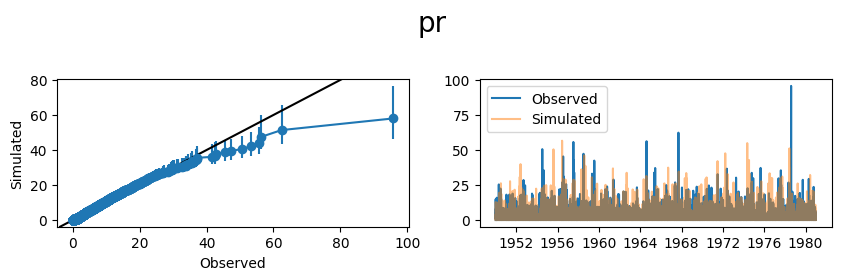

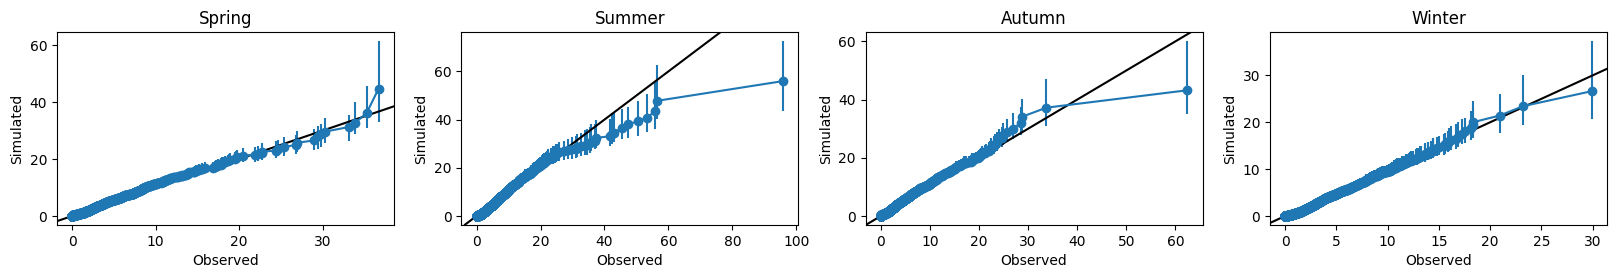

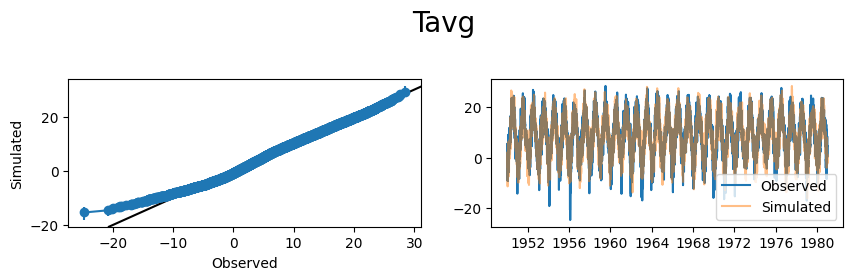

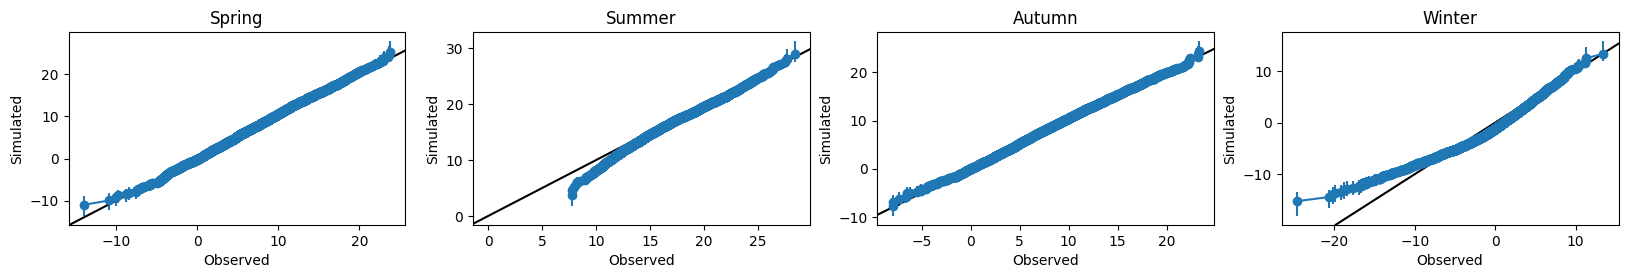

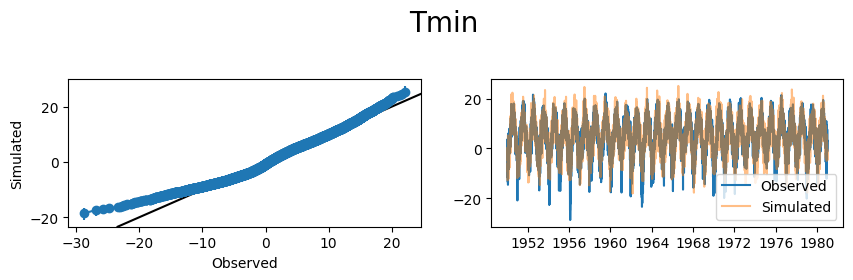

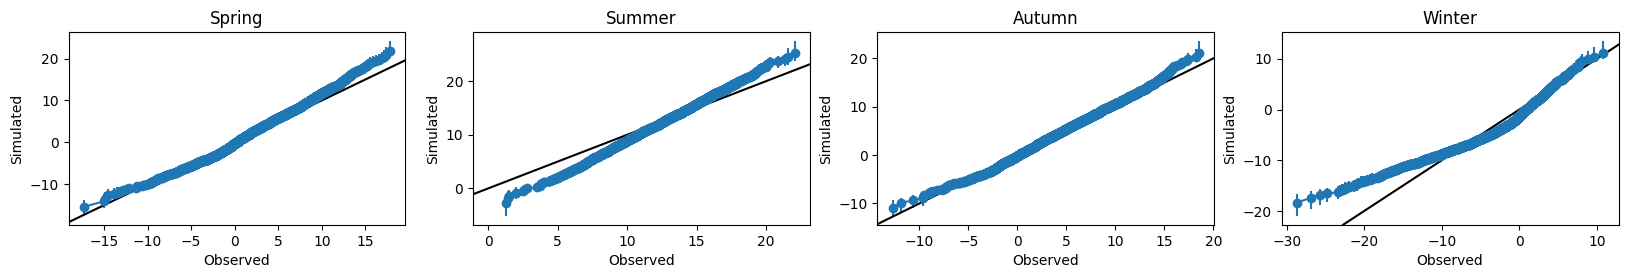

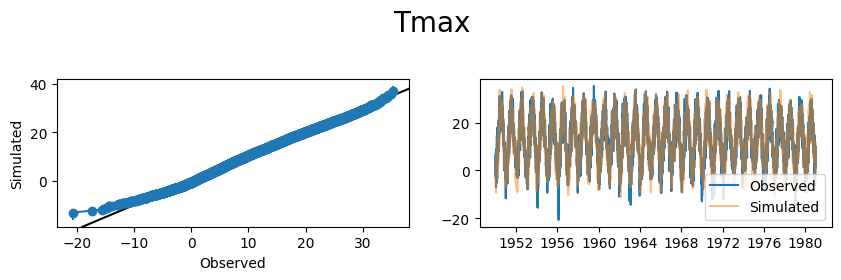

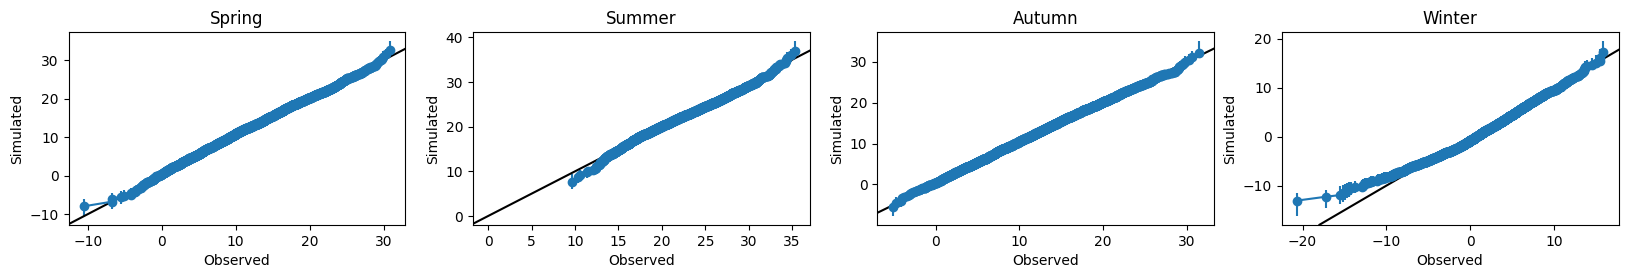

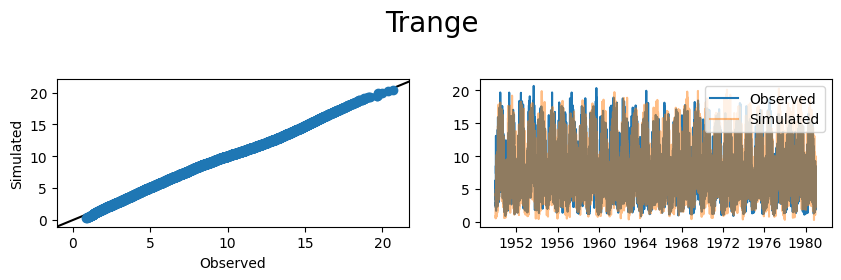

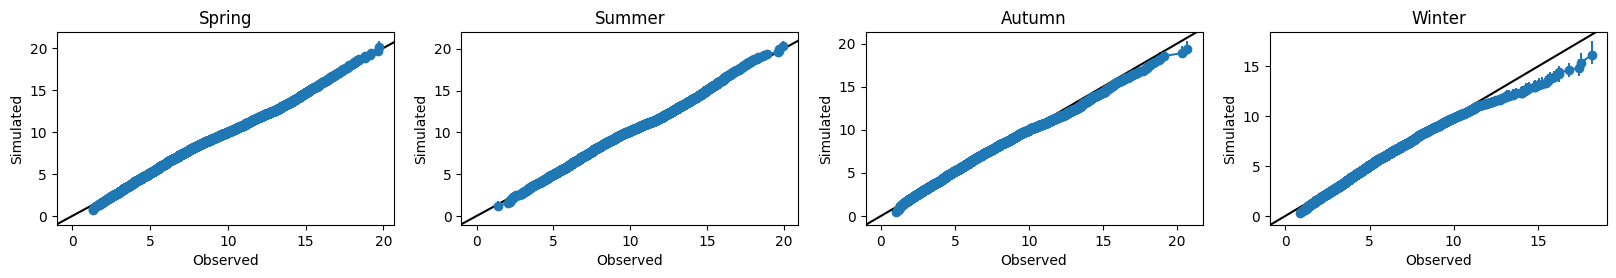

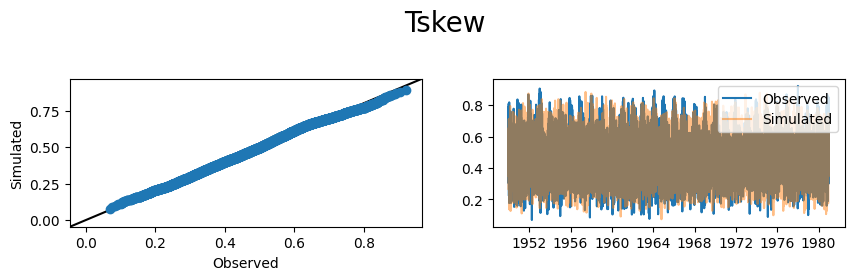

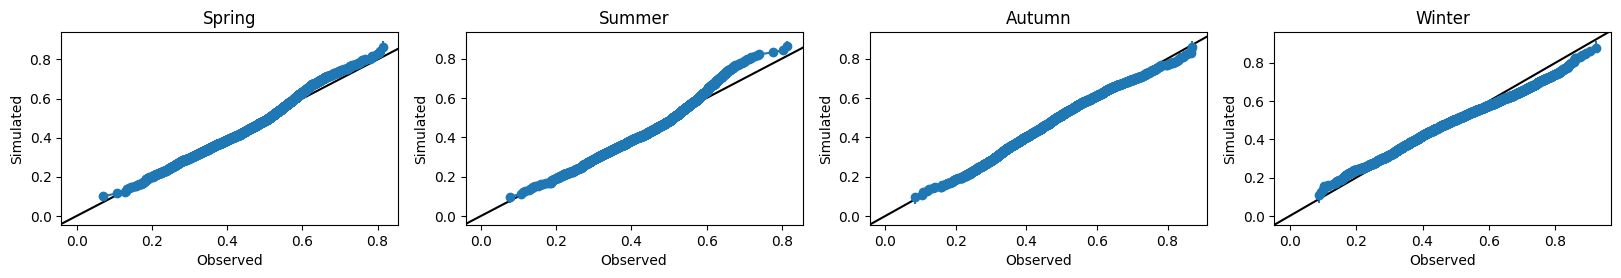

In [495]:
fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("pr", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(obs["prec"], svi_preds["prec"], ax = axs[0])
build_ts_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(obs["prec"], svi_preds["prec"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("Tavg", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(obs["Tavg"], svi_preds["Tavg"], ax = axs[0])
build_ts_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("Tmin", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(basin_data_train["Tair_min"], svi_preds["Tmin"], ax = axs[0])
build_ts_plot(basin_data_train["Tair_min"], svi_preds["Tmin"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(basin_data_train["Tair_min"], svi_preds["Tmin"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("Tmax", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(basin_data_train["Tair_max"], svi_preds["Tmax"], ax = axs[0])
build_ts_plot(basin_data_train["Tair_max"], svi_preds["Tmax"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(basin_data_train["Tair_max"], svi_preds["Tmax"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("Trange", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(obs["Trange"], svi_preds["Trange"], ax = axs[0])
build_ts_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(obs["Trange"], svi_preds["Trange"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

fig, axs = plt.subplots(1, 2, figsize = (10, 2.5))
fig.suptitle("Tskew", fontsize = 20)
plt.subplots_adjust(top=0.7)
build_qq_plot(obs["Tskew"], svi_preds["Tskew"], ax = axs[0])
build_ts_plot(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, ax = axs[1])
build_qq_plot_by_season(obs["Tskew"], svi_preds["Tskew"], basin_data_train.index, figsize = (20, 2.5))
plt.show()

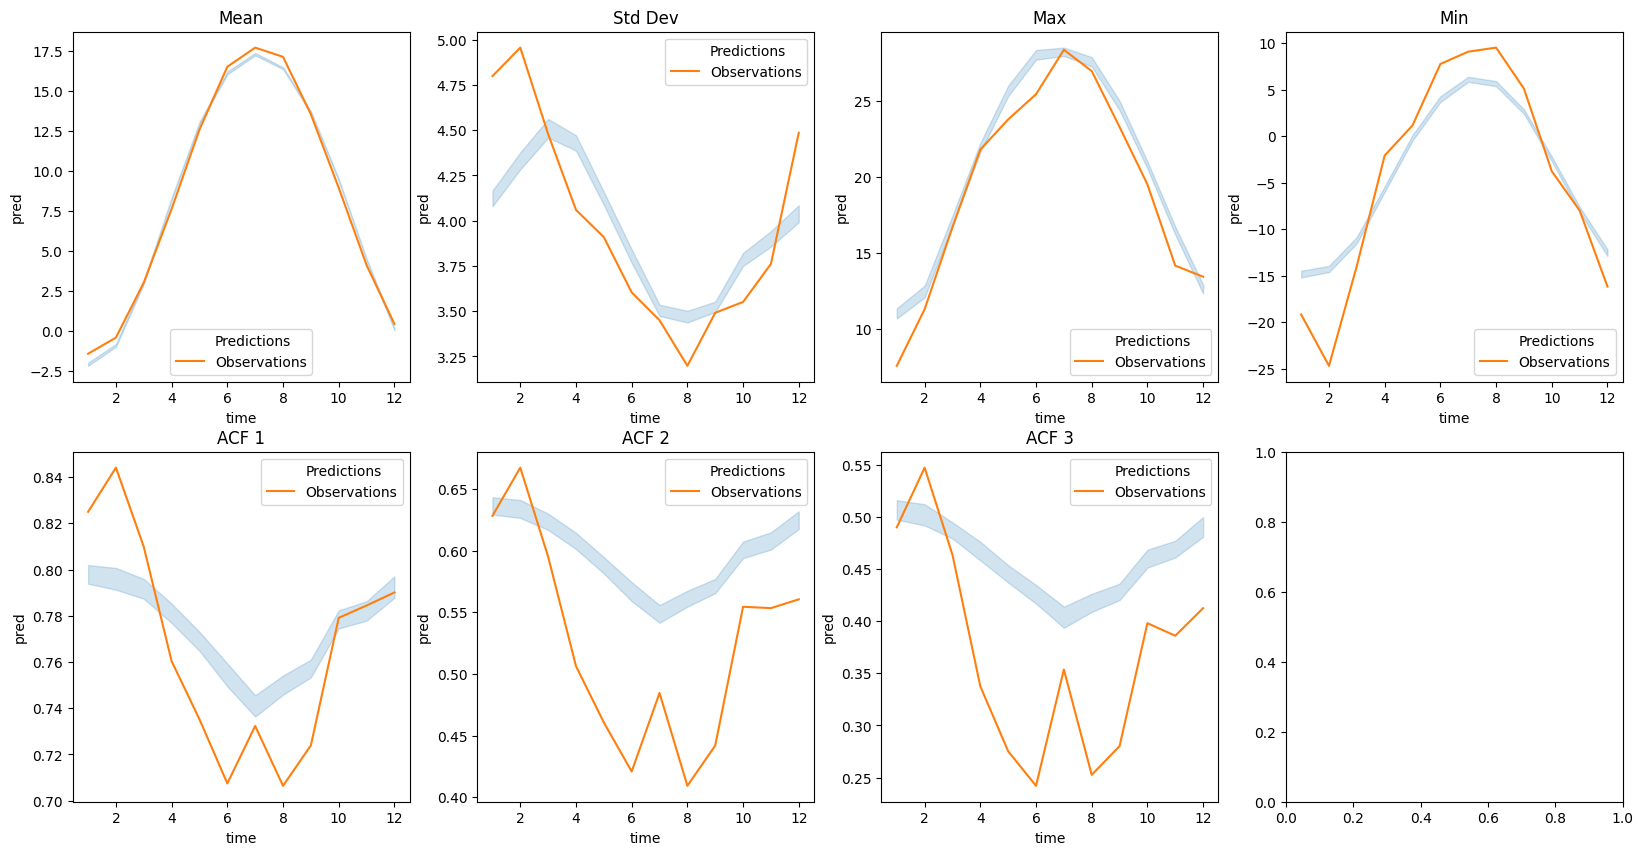

In [731]:
def get_mean_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).mean().drop(columns = "time").reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].mean().reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Mean")

def get_std_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).std().drop(columns = "time").reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].std().reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Std Dev")

def get_max_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).max().drop(columns = "time").reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].max().reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Max")

def get_min_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).min().drop(columns = "time").reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].min().reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Min")

def get_acf_plot(obs, pred, time, lag = 1, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable])["pred"].apply(lambda x: np.corrcoef(x[:(-lag)], x[lag:])[0,1]).reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].apply(lambda x: np.corrcoef(x[:(-lag)], x[lag:])[0,1]).reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title(f"ACF {lag}")

fig, axs = plt.subplots(2, 4, figsize = (20, 10))
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 2])
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 3])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 0], lag = 1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 1], lag = 2)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 2], lag = 3)


In [ ]:
fig, axs = plt.subplots(2, 4, figsize = (20, 10))
get_mean_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 0])
get_std_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 1])
get_max_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 2])
get_min_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[0, 3])
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 0], lag = 1)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 1], lag = 2)
get_acf_plot(obs["Tavg"], svi_preds["Tavg"], basin_data_train.index, ax = axs[1, 2], lag = 3)

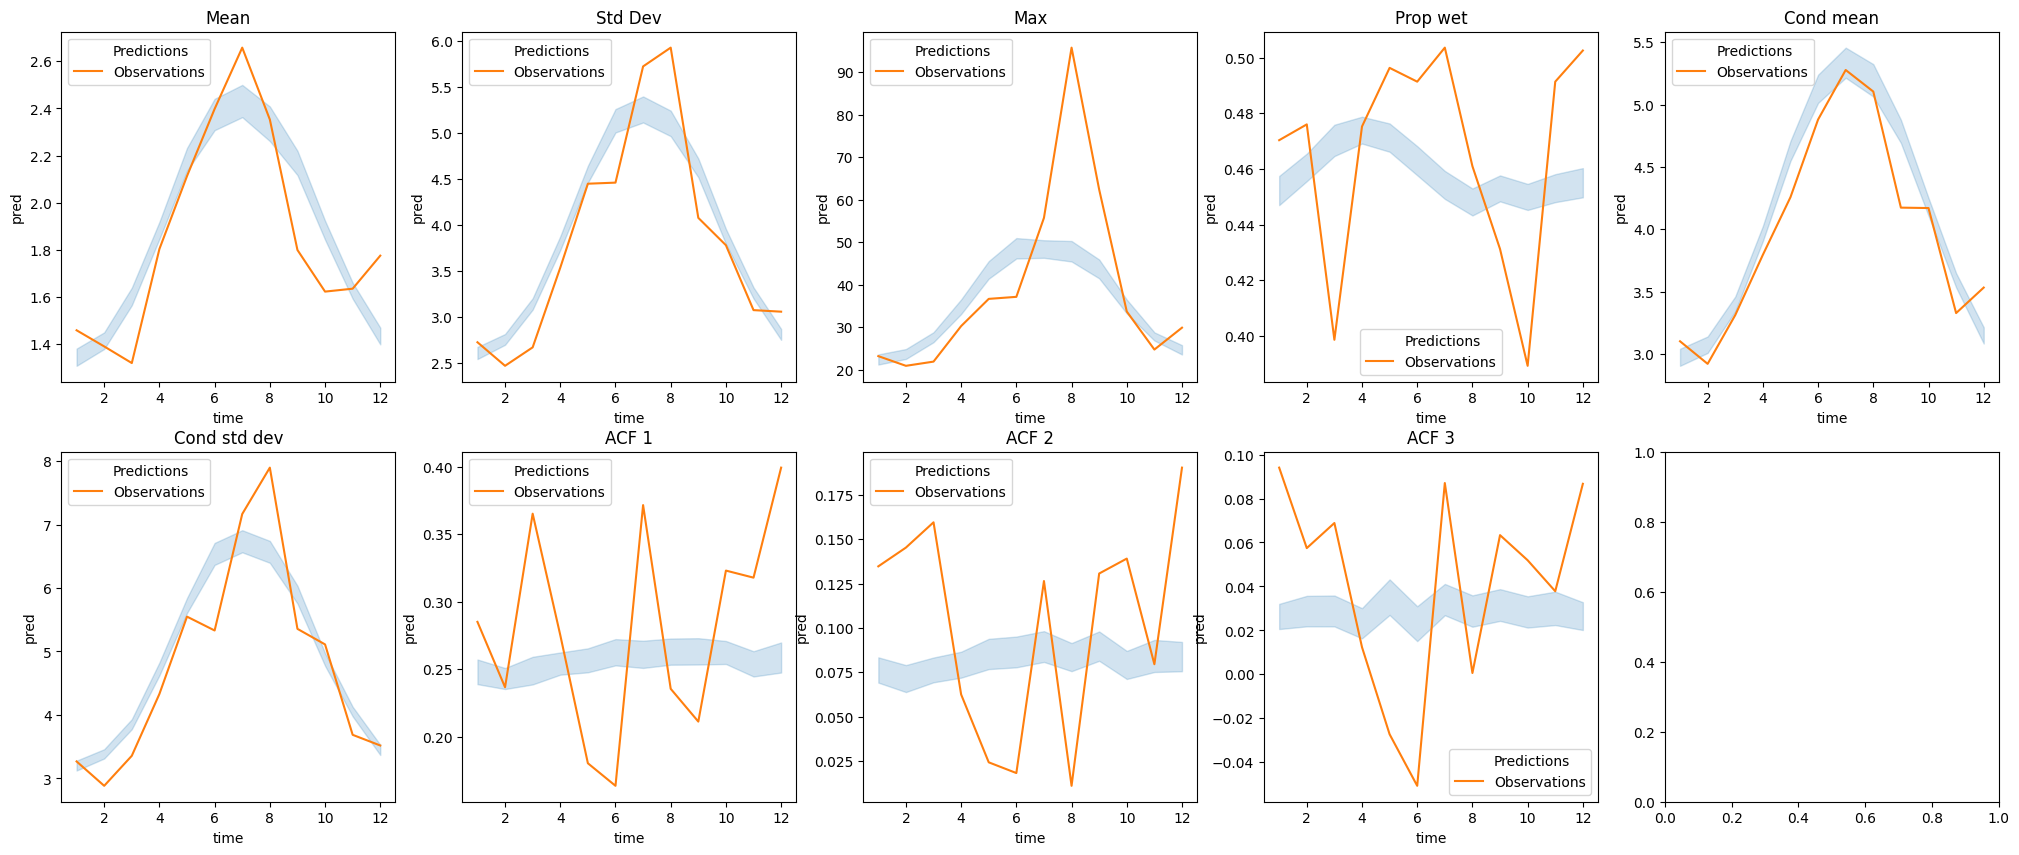

In [735]:
def get_cond_mean_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable])["pred"].apply(lambda x: x[x > 0].mean()).reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].apply(lambda x: x[x > 0].mean()).reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Cond mean")

def get_cond_std_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable])["pred"].apply(lambda x: x[x > 0].std()).drop(columns = "time").reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].apply(lambda x: x[x > 0].std()).reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Cond std dev")

def get_prop_wet_plot(obs, pred, time, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
        
    df_preds = pd.DataFrame(pred.squeeze().T)
    df_preds["time"] = time
    df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
    df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable])["pred"].apply(lambda x: np.mean(x > 0)).reset_index()
    
    df_obs = pd.DataFrame({"obs": obs.squeeze(), "time": time})
    df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].apply(lambda x: np.mean(x > 0)).reset_index()
    
    sns.lineplot(df_preds, x = "time", y = "pred", ax = ax, label = "Predictions", linestyle = "")
    sns.lineplot(df_obs, x = "time", y = "obs", ax = ax, label = "Observations")
    ax.set_title("Prop wet")

fig, axs = plt.subplots(2, 5, figsize = (25, 10))
get_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[0, 0])
get_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[0, 1])
get_max_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[0, 2])
get_prop_wet_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[0, 3])
get_cond_mean_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[0, 4])
get_cond_std_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[1, 0])
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[1, 1], lag = 1)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[1, 2], lag = 2)
get_acf_plot(obs["prec"], svi_preds["prec"], basin_data_train.index, ax = axs[1, 3], lag = 3)


In [701]:
df_preds = pd.DataFrame(svi_preds["Tavg"].squeeze().T)
df_preds["time"] = basin_data_train.index
df_preds = df_preds.melt(id_vars = "time", value_name = "pred")
#df_preds = df_preds.groupby([df_preds.time.dt.month, df_preds.variable]).min().drop(columns = "time").reset_index()

df_obs = pd.DataFrame({"obs": obs["Tavg"].squeeze(), "time": basin_data_train.index})
df_obs = df_obs.groupby(df_obs.time.dt.month)["obs"].min().reset_index()

In [721]:
df_preds.groupby([df_preds.time.dt.month, df_preds.variable])["pred"].apply(lambda x: np.corrcoef(x[:-1], x[1:])[0,1]).reset_index()

,time,variable,pred
0,1,0,0.820293
1,1,1,0.835940
2,1,2,0.833133
3,1,3,0.787329
4,1,4,0.768708
...,...,...,...
1195,12,95,0.826007
1196,12,96,0.779182
1197,12,97,0.778107
1198,12,98,0.771491


1.0

(2000, 4583.1)

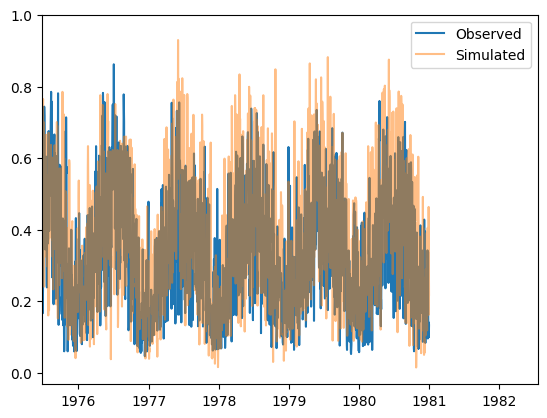

In [157]:
build_ts_plot(obs["Trange"], svi_preds["Trange"], basin_data_train.index)
plt.xlim(2000)

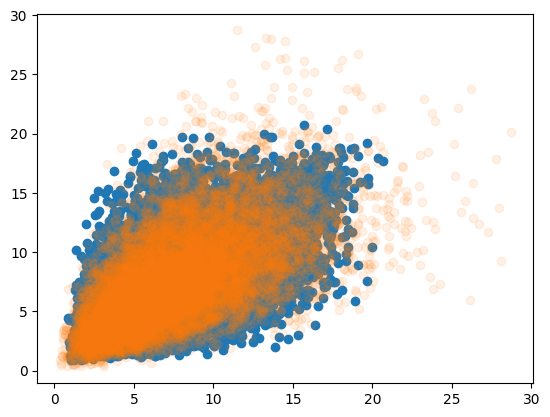

In [58]:
plt.scatter(obs["Trange"].squeeze()[1:], obs["Trange"].squeeze()[:-1])
plt.scatter(svi_preds["Trange"].squeeze()[0, 1:], svi_preds["Trange"].squeeze()[0, :-1], alpha = 0.1)


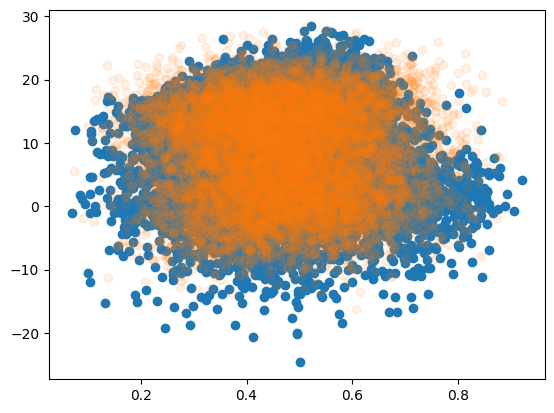

In [59]:
plt.scatter(obs["Tskew"].squeeze(), obs["Tavg"].squeeze())
plt.scatter(svi_preds["Tskew"].squeeze()[0, :], svi_preds["Tavg"].squeeze()[0, :], alpha = 0.1)


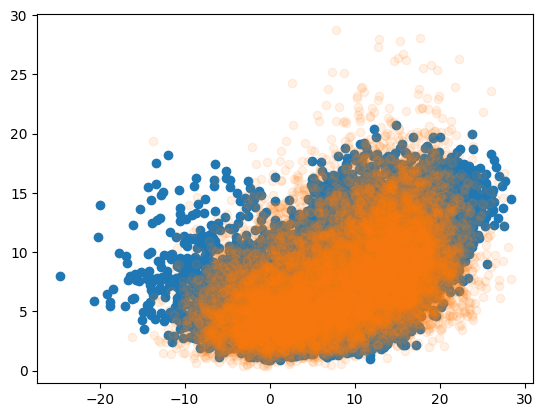

In [60]:
plt.scatter(obs["Tavg"].squeeze(), obs["Trange"].squeeze())
plt.scatter(svi_preds["Tavg"].squeeze()[0, :], svi_preds["Trange"].squeeze()[0, :], alpha = 0.1)


In [61]:
svi_preds["Trange"].mean(axis = 0).shape

(11323, 1)

C:\Users\jw1301\AppData\Local\Temp\ipykernel_29936\1205222382.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(obs["Trange"], label = "Obs")
C:\Users\jw1301\AppData\Local\Temp\ipykernel_29936\1205222382.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_preds["Trange"][0, :], label = "Pr

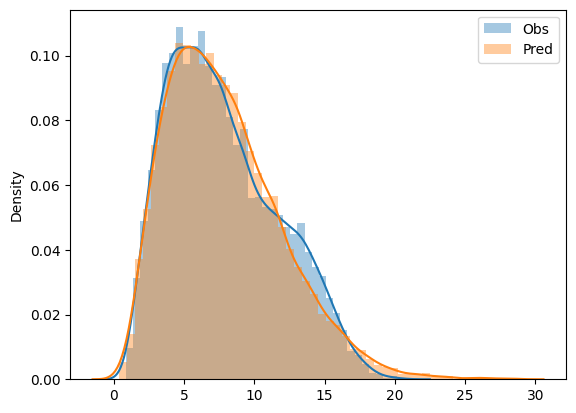

In [62]:
sns.distplot(obs["Trange"], label = "Obs")
sns.distplot(svi_preds["Trange"][0, :], label = "Pred")
plt.legend()

In [830]:
obs["Trange"].max()

Array(20.692028, dtype=float32)

In [752]:
import scipy.stats
pred_range = scipy.special.inv_boxcox(svi_preds["Trange"], 0.400313763002924)
pred_min = svi_preds["Tavg"] - svi_preds["Tskew"]*pred_range
pred_max = pred_min + pred_range

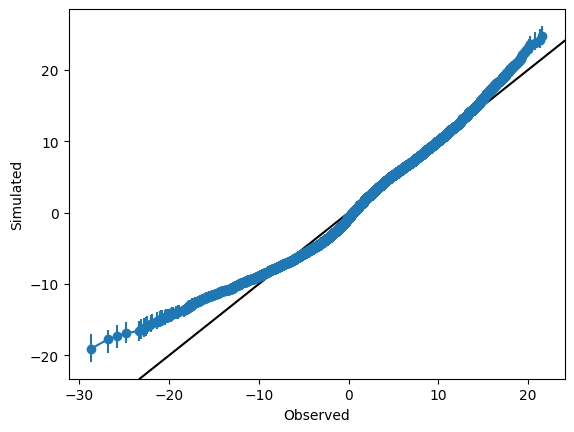

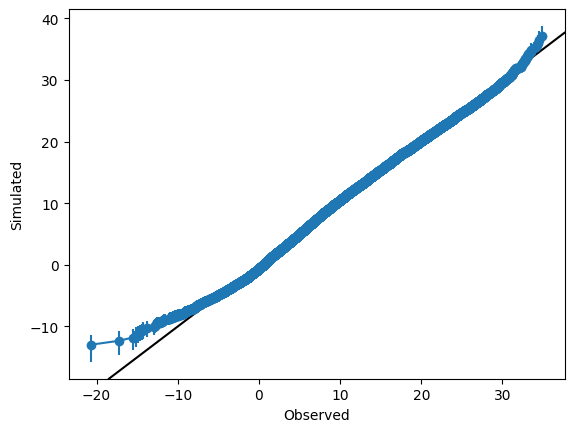

In [758]:
build_qq_plot(basin_data_train["Tair_min"], pred_min)
build_qq_plot(basin_data_train["Tair_max"], pred_max)


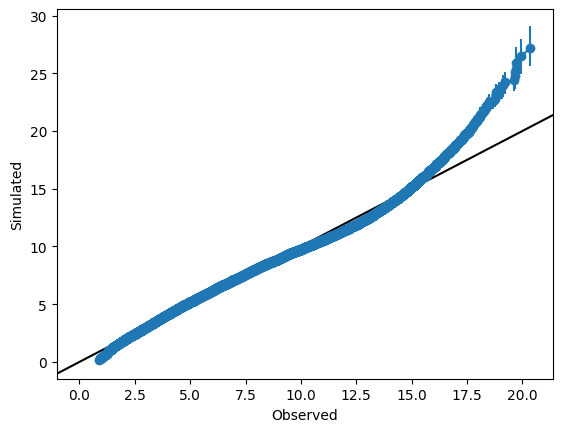

In [760]:
build_qq_plot(basin_data_train["Tair_max"] - basin_data_train["Tair_min"], pred_range)


In [653]:
from scipy import stats

t_vals, param = stats.boxcox(obs["Trange"].squeeze())
t_vals

array([1.606083 , 2.751909 , 0.9522307, ..., 1.4076344, 0.9026414,
       1.3063653], dtype=float32)

In [438]:
obs["Trange"].min()

Array(0.867303, dtype=float32)

In [349]:
svi_preds["Trange"][0, :].min()

Array(0.01021973, dtype=float32)

In [415]:
basin_data_train["Tair_mean"].squeeze()

time
1950-01-01   -4.591548
1950-01-02   -0.241045
1950-01-03    1.184898
1950-01-04   -1.175316
1950-01-05   -3.065112
                ...   
1980-12-27    0.331905
1980-12-28    0.223185
1980-12-29    2.814683
1980-12-30    4.762229
1980-12-31    4.625784
Name: Tair_mean, Length: 11323, dtype: float64

C:\Users\jw1301\AppData\Local\Temp\ipykernel_11164\4078811816.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(obs["Trange"])
C:\Users\jw1301\AppData\Local\Temp\ipykernel_11164\4078811816.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(svi_preds["Trange"][0, :])


<Axes: ylabel='Density'>

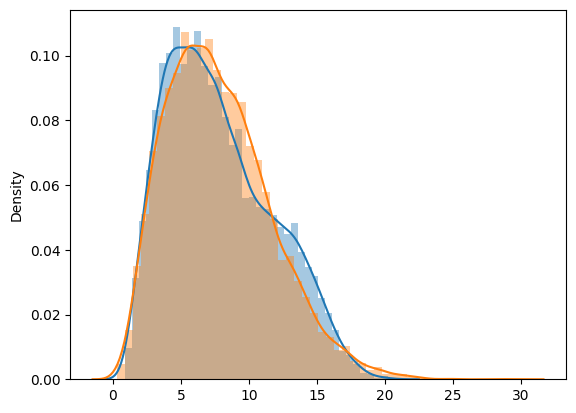

In [327]:
svi_preds.keys()

,id,Tair_mean,Tair_max,Tair_min,prec
time,,,,,
1950-01-01,6340800,-4.591548,-2.227974,-5.684343,0.000000
1950-01-02,6340800,-0.241045,0.977567,-5.415905,14.836433
1950-01-03,6340800,1.184898,2.021821,-0.218732,3.409973
1950-01-04,6340800,-1.175316,0.839024,-2.044282,2.305814
1950-01-05,6340800,-3.065112,-1.902678,-4.938058,9.280007
...,...,...,...,...,...
1980-12-27,6340800,0.331905,1.605490,-1.140769,0.000000
1980-12-28,6340800,0.223185,0.837982,-1.304325,0.000000
1980-12-29,6340800,2.814683,3.277682,0.223794,0.000000


In [261]:
np.median(sim_sorted, axis = 0)[(np.quantile(sim_sorted, 0.9, axis = 0) - np.median(sim_sorted, axis = 0)) < 0]

array([], dtype=float32)

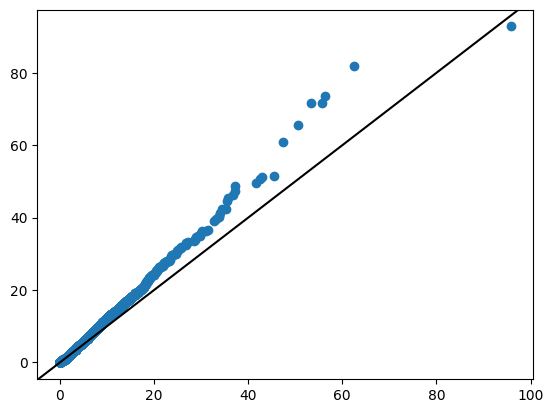

In [245]:
plt.scatter(obs_sorted, np.max(sim_sorted, axis = 0))
plt.axline((0,0),slope=1,c='black')

(2, 11323)

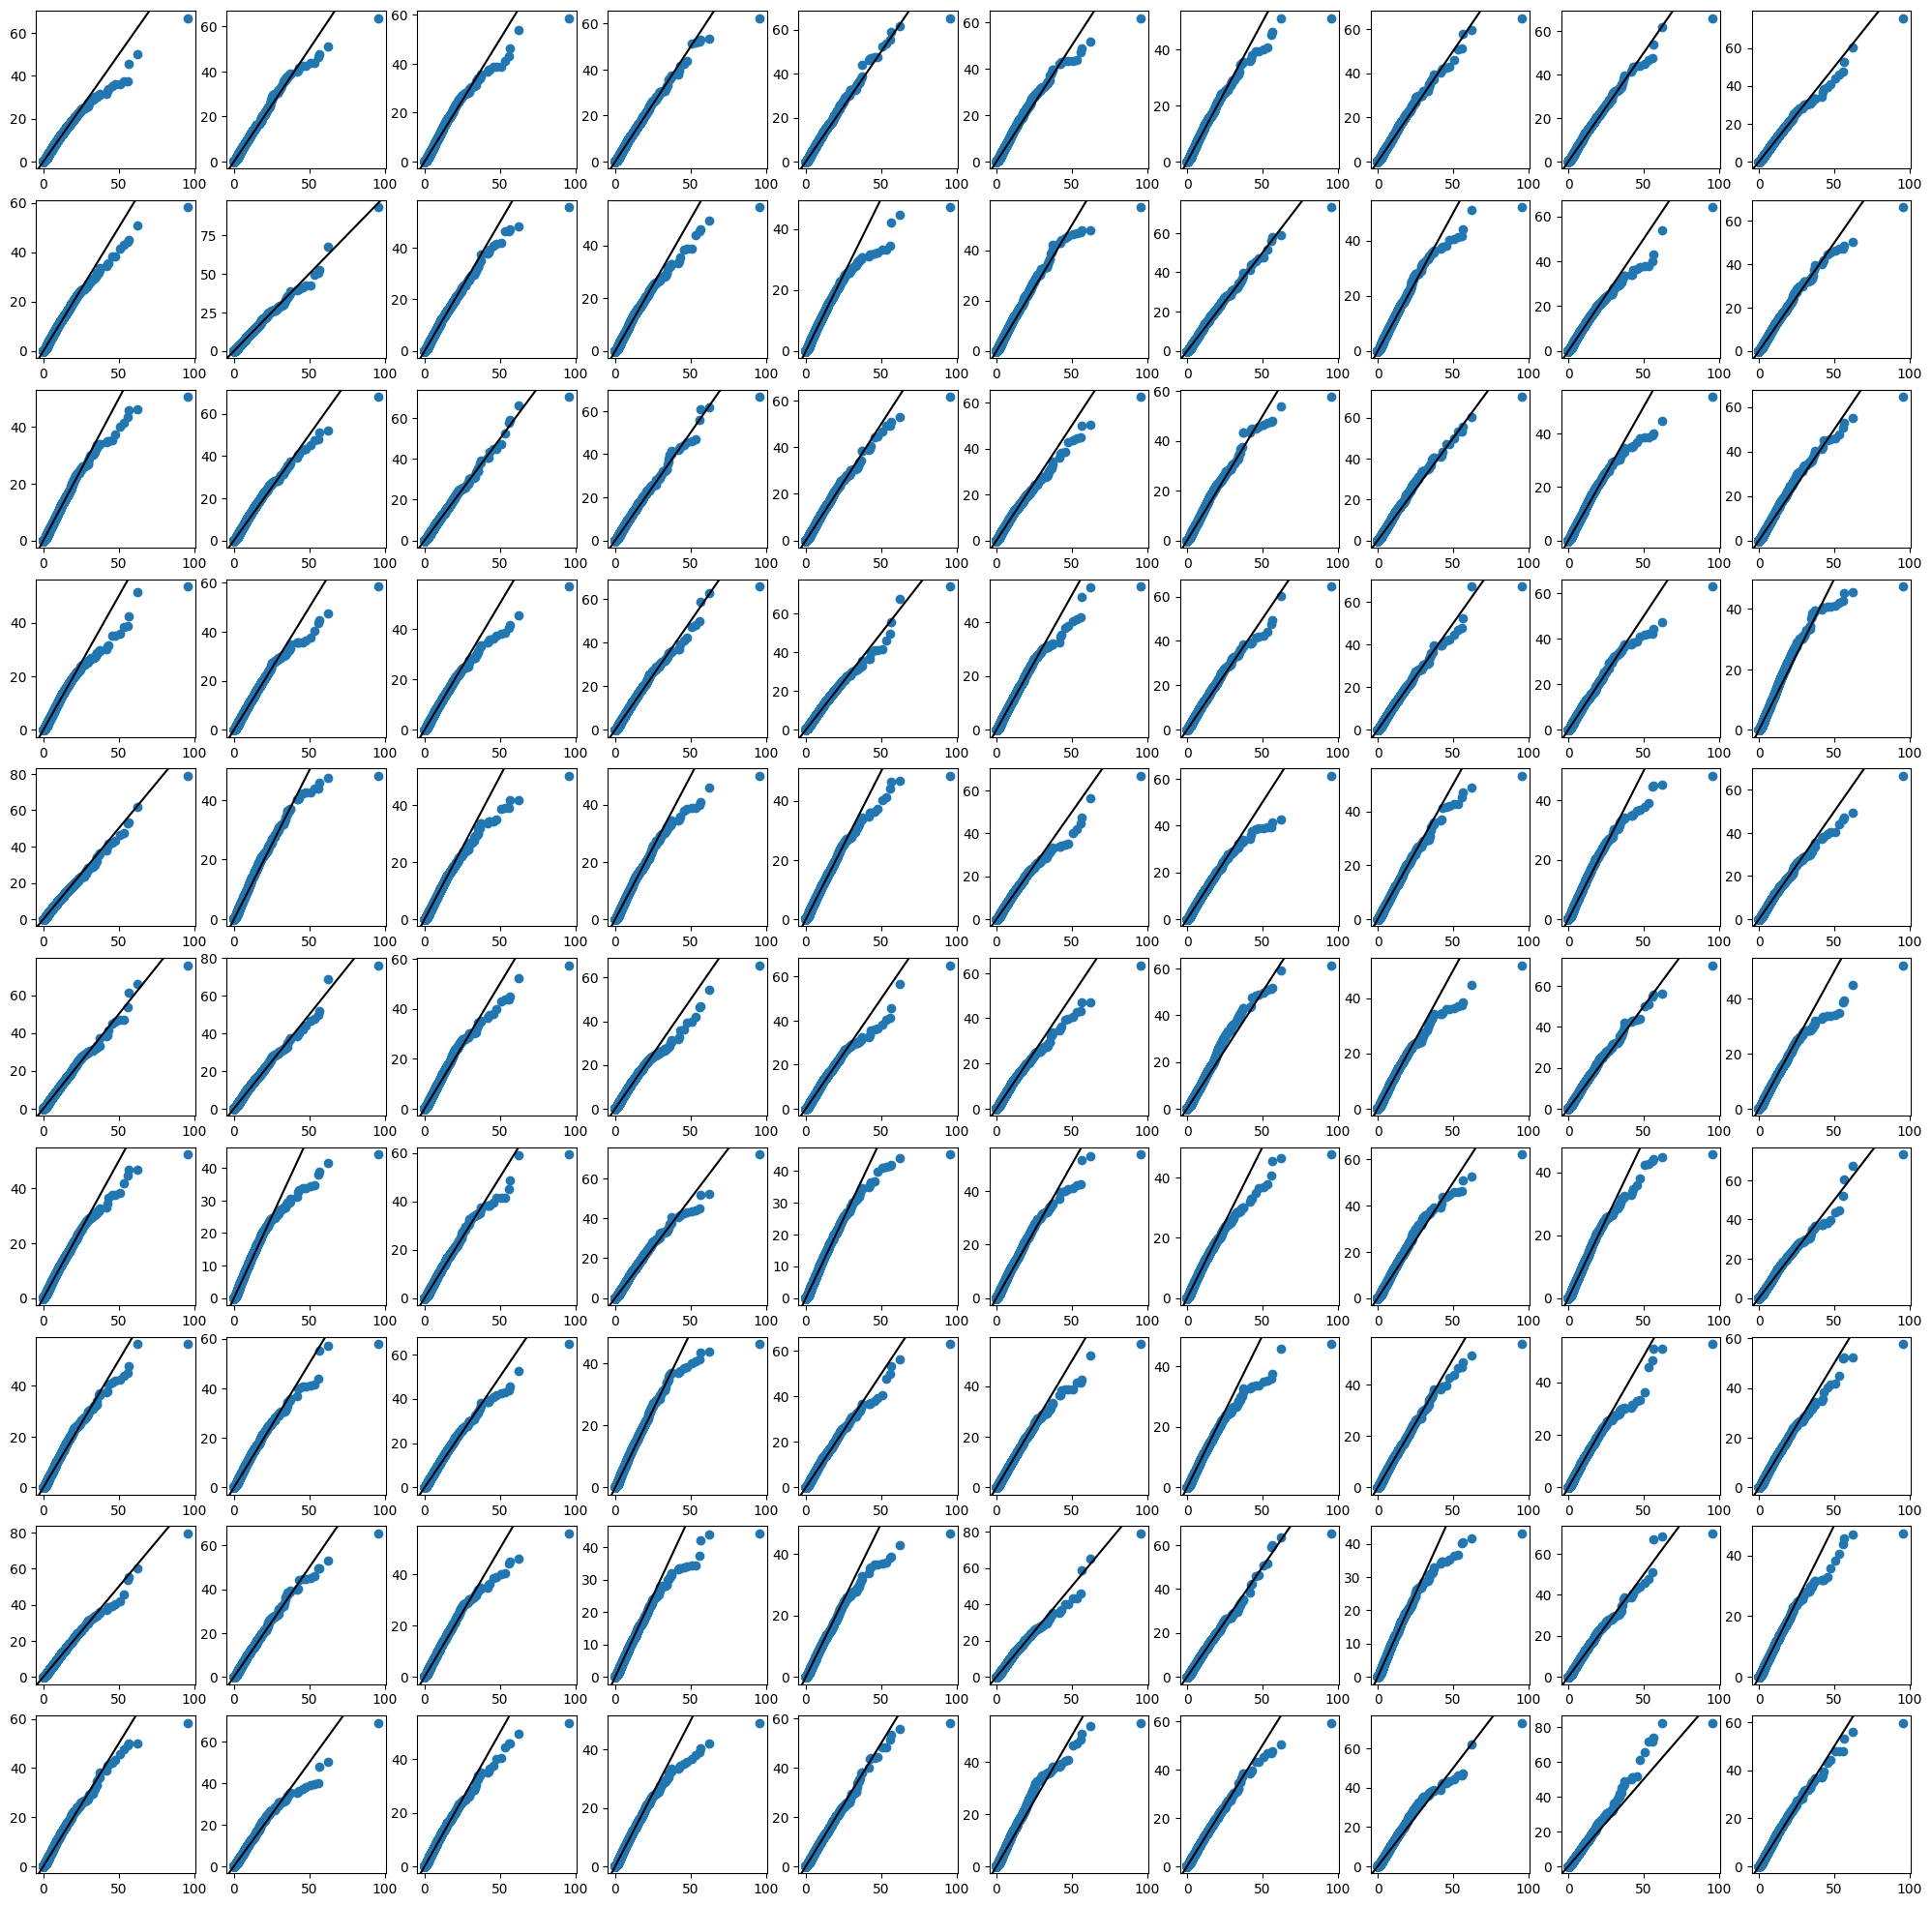

In [99]:
svi_preds["prec"].squeeze().T.sort(axis = 0).shape

(11323, 100)

In [81]:
np.median(np.sort(svi_preds["Tskew"].squeeze(), axis = 1), axis = 0).shape

(11323,)

In [77]:
np.sort(basin_data_train["prec"].squeeze())

array([ 0.        ,  0.        ,  0.        , ..., 56.28555291,
       62.4079655 , 95.81037402])

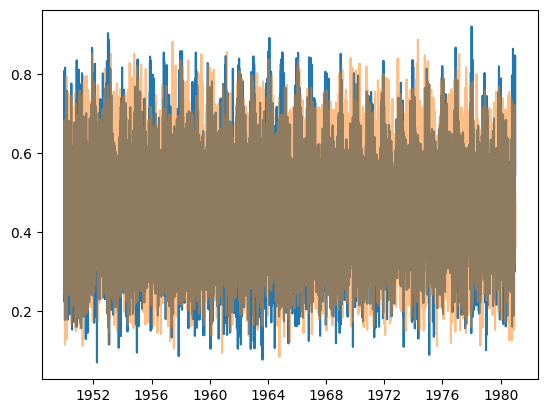

In [70]:
plt.plot(basin_data_train.index, obs["Tskew"].squeeze())
plt.plot(basin_data_train.index, svi_preds["Tskew"].squeeze()[0, :], alpha = 0.5)

In [60]:
obs.keys()

dict_keys(['prec', 'Tavg', 'Trange', 'Tskew'])

## Model diagnostics

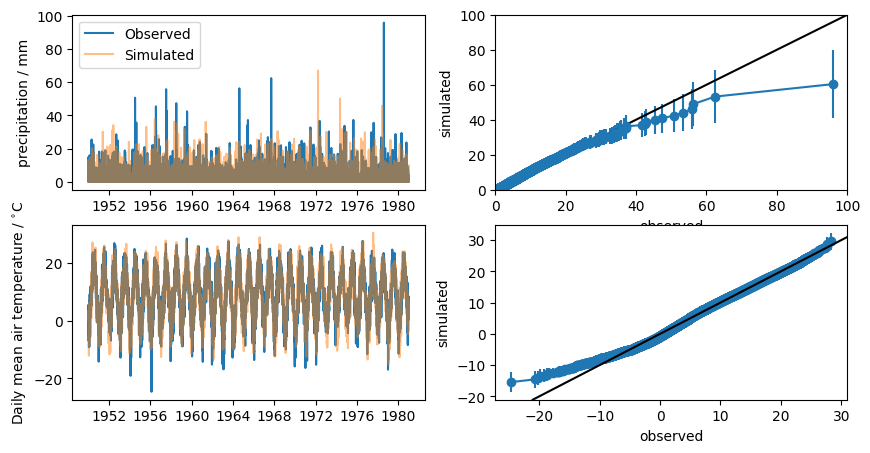

In [40]:
fig, axs = plt.subplots(2,2,figsize=(10,5))#,dpi=300)
prec_preds = svi_preds['prec'].squeeze().T.sort(axis=0)
prec_obs = obs['prec'].squeeze().sort()
p1 = axs[0,0].plot(basin_data_train.index, obs['prec'].squeeze())
p2 = axs[0,0].plot(basin_data_train.index, svi_preds['prec'].squeeze()[0,:], alpha=0.5)
axs[0,0].set_ylabel("precipitation / mm")
axs[0,0].legend(handles=[p1[0],p2[0]], labels=["Observed","Simulated"])
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
axs[0,1].errorbar(prec_obs, prec_preds.mean(axis=1), yerr=2*prec_preds.std(axis=1), marker="o")
axs[0,1].axline((0,0),slope=1,c='black')
axs[0,1].set_xlabel("observed")
axs[0,1].set_ylabel("simulated")
axs[0,1].set_xlim(0,100)
axs[0,1].set_ylim(0,100)
# air temperature
axs[1,0].plot(basin_data_train.index, obs['Tavg'].squeeze())
axs[1,0].plot(basin_data_train.index, svi_preds['Tavg'].squeeze().T[:,0], alpha=0.5)
axs[1,0].set_ylabel("Daily mean air temperature / $^{\\circ}$C")
Tavg_preds = svi_preds['Tavg'].squeeze().T.sort(axis=0)
Tavg_obs = obs['Tavg'].squeeze().sort()
# plt.scatter(prec_obs, prec_preds.mean(axis=1))
axs[1,1].errorbar(Tavg_obs, Tavg_preds.mean(axis=1), yerr=2*Tavg_preds.std(axis=1), marker="o")
axs[1,1].axline((0,0),slope=1,c='black',zorder=10)
axs[1,1].set_xlabel("observed")
axs[1,1].set_ylabel("simulated")
#plt.savefig("../plots/basin_6340800_calibrated_Tair_prec.png")
plt.show()

In [76]:
print(f"Correlation between consecutive days in sim {np.corrcoef((svi_preds['prec'] <= 0).squeeze().T[:-1,0], (svi_preds['prec'] <= 0).squeeze().T[1:,0])[1,0]} and obs {np.corrcoef((obs['prec'] <= 0).squeeze()[:-1], (obs['prec'] <= 0).squeeze()[1:])[1,0]}")

Correlation between consecutive days in sim 0.33304353728591063 and obs 0.3445067127026181


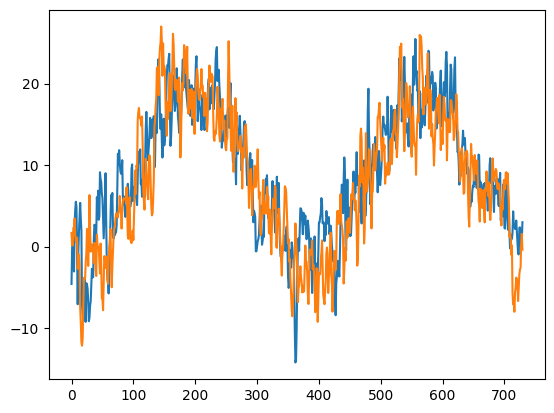

In [42]:
plt.plot(obs['Tavg'].squeeze()[:2*365])
plt.plot(svi_preds['Tavg'].squeeze()[0,:2*365])

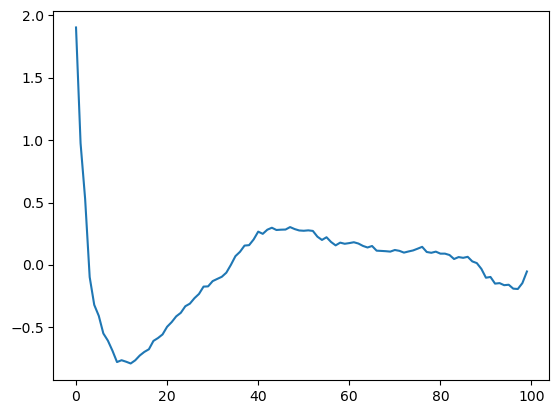

In [24]:
obs_qs = np.quantile(Tavg_obs, np.linspace(0.01,0.99,100))
sim_qs = np.quantile(Tavg_preds.reshape((-1,)), np.linspace(0.01,0.99,100))
# plt.plot(obs_qs, sim_qs)
# plt.axline((0,0),slope=1,c="black")
plt.plot(sim_qs - obs_qs)

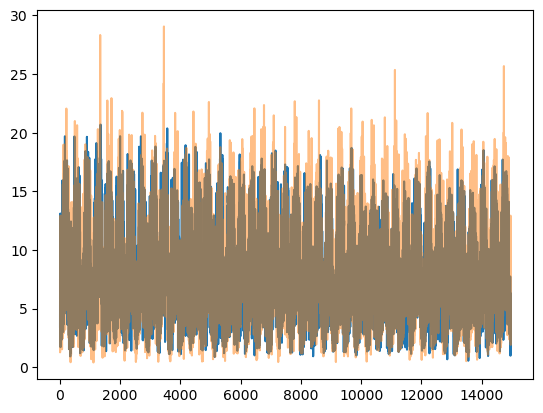

In [25]:
plt.plot(obs['Trange'].squeeze())
plt.plot(svi_preds['Trange'].squeeze().T[:,0], alpha=0.5)

In [26]:
from scipy.stats import gamma
Trange_dist_fit = gamma.fit(obs['Trange'].squeeze())

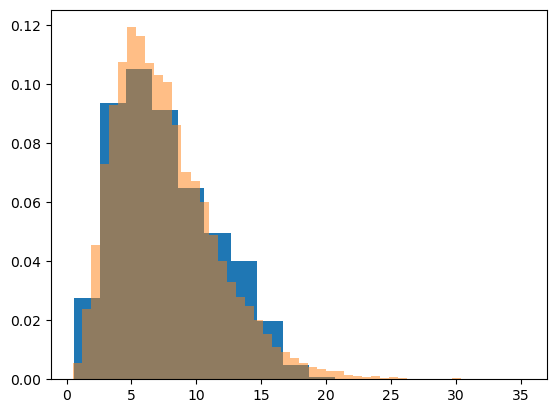

In [27]:
plt.hist(obs['Trange'].squeeze(), density=True)
plt.hist(gamma.rvs(*Trange_dist_fit, size=(len(obs['Trange'].squeeze()),)), alpha=0.5, bins=50, density=True);

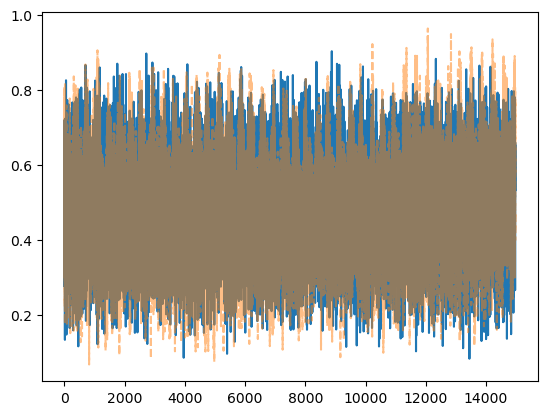

In [28]:
plt.plot(svi_preds['Tskew'].squeeze().T[:,0])
plt.plot(obs['Tskew'].squeeze(), alpha=0.5, linestyle='--')

In [29]:
# prng = random.PRNGKey(1234)
# map_guide = AutoDelta(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
# map_result = wgen.fit(10_000, map_guide, subsample_time=1000, rng=prng)
# with numpyro.handlers.seed(rng_seed=0):
#     map_params = map_guide(map_result.params)
# map_params

In [30]:
# from numpyro.infer import MCMC, NUTS, HMCECS

# # mcmc_kernel = BarkerMH(wx.step_wgen, step_size=0.001, target_accept_prob=0.65, dense_mass=True)
# proxy = HMCECS.taylor_proxy(map_params)
# mcmc_kernel = HMCECS(NUTS(wgen.step, init_strategy=numpyro.infer.init_to_median), num_blocks=10, proxy=proxy)
# # mcmc_kernel = NUTS(wx.step_wgen)
# mcmc = MCMC(mcmc_kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method="parallel")
# prng = random.PRNGKey(1234)
# mcmc.run(prng, subsample_time=100)
# mcmc.print_summary()

In [31]:
# import arviz as az

# with numpyro.handlers.seed(rng_seed=0):
#     idata = az.from_numpyro(mcmc)
# az.plot_trace(idata)

# SBI

In [37]:
import torch
from jax2torch.jax2torch import jax2torch, j2t, t2j
from sbi.inference import SNPE, SNLE, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior, process_simulator

torch.manual_seed(1234)

In [38]:
def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tair90 = jnp.quantile(Tair_mean, 0.99, axis=0)
    Tair50 = jnp.quantile(Tair_mean, 0.50, axis=0)
    Tair10 = jnp.quantile(Tair_mean, 0.01, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    tdd = jnp.mean(jnp.where(Tair_mean > 0, Tair_mean, 0), axis=0)
    fdd = jnp.mean(jnp.where(Tair_mean <= 0, Tair_mean, 0), axis=0)
    return jnp.stack([Tair10, Tair50, Tair90, Trange, Tskew, tdd, fdd])

def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pcondmean = jnp.nanmean(jnp.where(pr > 0, pr, jnp.nan), axis=axis)
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pcondmean, pmean, rp95, fwd, cdd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    #Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    #return jnp.concat([precip_stats, Tair_stats], axis=0)
    return precip_stats[0:1, :]
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [39]:
svi_preds["prec"].mean()

Array(1.8646963, dtype=float32)

## First example: trend in mean precip

In [41]:
sim, sim_prior = wgen.simulator(observable=wgen_summary_stats, rng_seed=1234)
wgen_sbi = jax2torch(sim) # Convert to torch for sbi

Get and modify observational statistics:

In [43]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = wgen_summary_stats(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

#obs_stats = obs_stats.at[1].set(obs_stats[1] + 2)

print(f"obs: {obs_stats}")

obs_stats = obs_stats * 1.5

obs_stats

obs: [[4.00429]]


Array([[6.0064354]], dtype=float32)

Build prior 

In [45]:
gamma = 0.001#0.1 #0.001

svi_posterior = guide.get_posterior(svi_result.params)
sbi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix +  gamma* jnp.eye(svi_posterior.covariance_matrix.shape[0])))

#scale_factor = 2

#svi_posterior = guide.get_posterior(svi_result.params)
#sbi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*jnp.diag(svi_posterior.covariance_matrix)))

In [ ]:
jnp.diag(svi_posterior.covariance_matrix)

In [ ]:
#sbi_proposal_samples = sbi_proposal.sample((1000,))
#sbi_proposal_samples.std()

In [ ]:
svi_posterior.mean.shape

Sample from proposal and run sims:

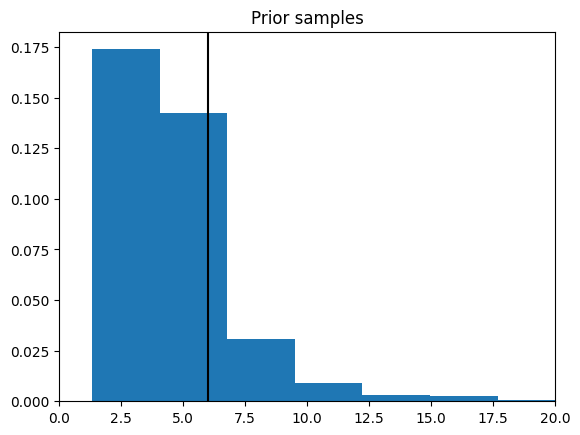

In [48]:
sbi_proposal_samples = sbi_proposal.sample((1000,))
sbi_proposal_obs = wgen_sbi(sbi_proposal_samples)
plt.hist(sbi_proposal_obs.numpy(), bins = 20, density = True)
plt.axvline([obs_stats[0,:]], c= "black")
plt.title("Prior samples")
plt.xlim(0, 20)
plt.show()


In [57]:
sbi_alg = SNPE(sbi_proposal)
num_simulations = 1000
num_rounds = 3
proposal = sbi_proposal
for i in range(num_rounds):
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=500)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats.squeeze()))
    proposal = sbi_posterior

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:04<00:00, 15.62it/s]


 Neural network successfully converged after 95 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 140 epochs.

Running 1000 simulations.: 100%|██████████| 1000/1000 [01:52<00:00,  8.86it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

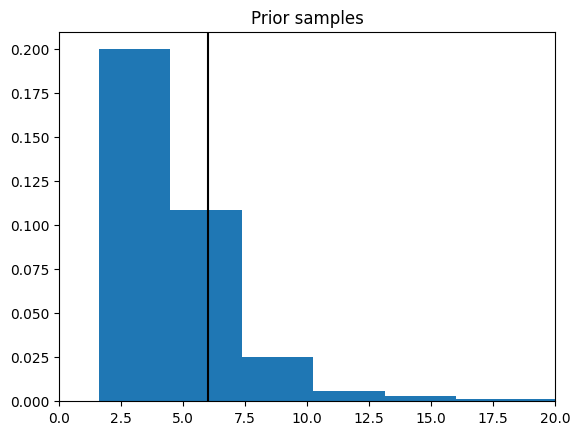

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1531.67it/s]


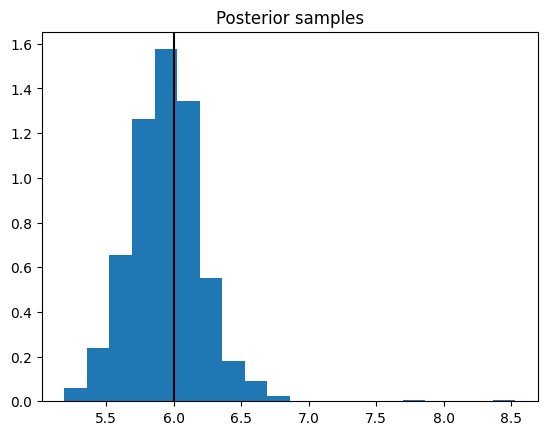

In [63]:
samples = sbi_proposal.sample((1000,))
sbi_proposal_sims = wgen_sbi(samples)
plt.hist(sbi_proposal_sims.numpy(), bins = 20, density = True)
plt.axvline([obs_stats[0,:]], c= "black")
plt.title("Prior samples")
plt.xlim(0, 20)
plt.show()

samples = sbi_posterior.sample((1000,))
sbi_posterior_sims = wgen_sbi(samples)
plt.hist(sbi_posterior_sims.numpy(), bins = 20, density = True)
plt.axvline([obs_stats[0,:]], c= "black")
plt.title("Posterior samples")
plt.show()


In [64]:
simulator_get_rain, _ = wgen.simulator(rng_seed=1234)
simulator_get_rain = jax2torch(simulator_get_rain)

theta = j2t(svi_posterior.mean).unsqueeze(0)
rain_samples = simulator_get_rain(theta)

theta_adj = samples.median(0)[0].unsqueeze(0)
rain_samples_adj = simulator_get_rain(theta_adj)

In [65]:
rain_fut = rain_samples_adj[0, :, 0]
rain_hist = rain_samples[0, :, 0]
rain_obs = obs["prec"].flatten()

In [66]:
print(f"Cond mean hist {rain_hist[rain_hist > 0].mean()}, cond mean fut: {rain_fut[rain_fut > 0].mean()}")

Cond mean hist 4.1219401359558105, cond mean fut: 5.900311470031738


In [67]:
import seaborn as sns

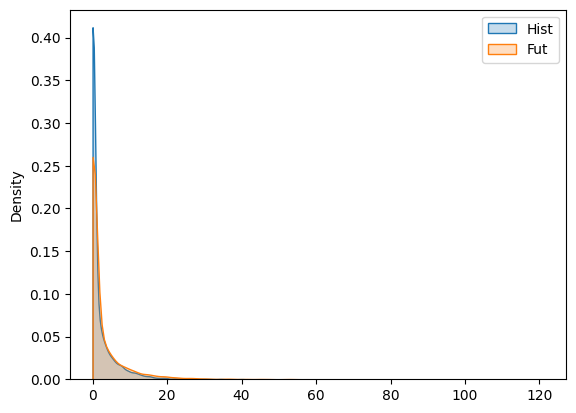

In [68]:
sns.kdeplot(rain_hist, cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut, cut = 0, fill = True, label = "Fut")
plt.legend()

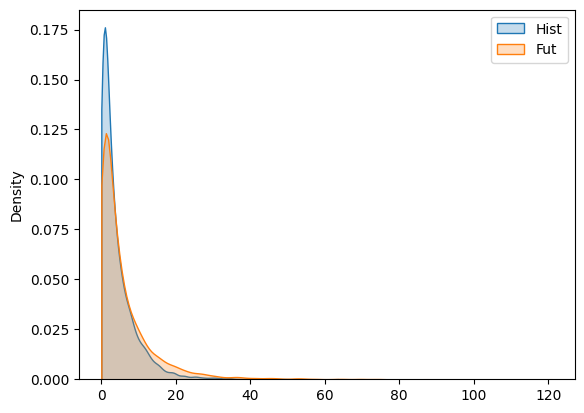

In [69]:
sns.kdeplot(rain_hist[rain_hist > 0], cut = 0, fill = True, label = "Hist")
sns.kdeplot(rain_fut[rain_fut > 0], cut = 0, fill = True, label = "Fut")
plt.legend()

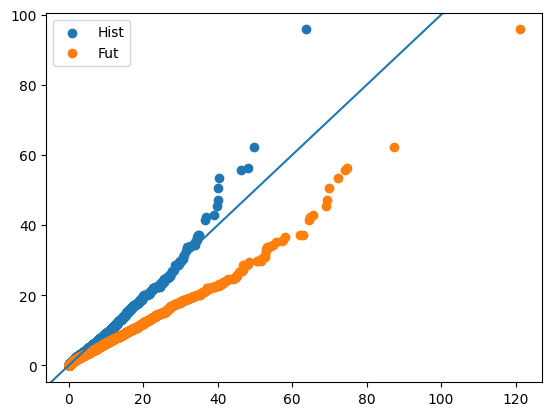

In [70]:
plt.scatter(np.sort(rain_hist), np.sort(rain_obs), label = "Hist")
plt.scatter(np.sort(rain_fut), np.sort(rain_obs), label = "Fut")
plt.axline((0,0), slope = 1)
plt.legend()

## Other

In [94]:
def precip_summary_stats(pr, cdd_thresh=0.0, axis=0):
    pmean = jnp.mean(pr, axis=axis)
    p95 = jnp.nanquantile(jnp.where(pr > 0, pr, jnp.nan), 0.95, axis=axis)
    rp95 = jnp.nanmean(jnp.where(pr > p95, pr, jnp.nan), axis=axis)
    fwd = jnp.mean(pr > 0, axis=axis)
    cdd = wx.utils.cumulative_dry_days(pr, threshold=cdd_thresh, axis=axis)
    return jnp.stack([pmean, rp95, fwd, cdd])

def tair_summary_stats(Tair_mean, Tair_min, Tair_max):
    Tavg = jnp.mean(Tair_mean, axis=0)
    Trange = jnp.mean(Tair_max - Tair_min, axis=0)
    Tskew = jnp.mean((Tair_mean - Tair_min) / (Tair_max - Tair_min), axis=0)
    ftd = jnp.mean(jnp.where(Tair_mean > 0, 1, 0), axis=0)
    # ffd = jnp.mean(jnp.where(Tair_mean <= 0, 1, 0), axis=0)
    return jnp.stack([Tavg, Trange, Tskew, ftd])

def wgen_summary_stats(ts, precip, Tmin, Tavg, Tmax):
    precip_stats = precip_summary_stats(precip)
    Tair_stats = tair_summary_stats(Tavg, Tmin, Tmax)
    return jnp.concat([precip_stats, Tair_stats], axis=0)
    # return precip_stats

summary_stat_names = ["prec_mean", "rp95", "norm wet days", "mean dry spell length", "Tair_mean", "Tair_range", "Tair_skew", "norm thaw days"]

In [96]:
wgen_sim, wgen_prior = wgen.simulator(observable=wgen_summary_stats, rng_seed=1234)

In [98]:
sim_stats = wgen_sim(wgen_prior.sample(jax.random.PRNGKey(0), (10,)))
sim_stats.shape

(10, 8)

In [99]:
obs['Tmin'] = obs['Tavg'] - obs['Tskew']*obs['Trange']
obs['Tmax'] = obs['Tmin'] + obs['Trange']
obs_stats = wgen_summary_stats(wgen.timestamps[0,:,:], obs['prec'].T, obs['Tmin'].T, obs['Tavg'].T, obs['Tmax'].T)
obs_stats

Array([[ 4.00429   ],
       [20.212057  ],
       [ 0.4654244 ],
       [ 3.2772062 ],
       [ 8.347303  ],
       [ 7.7874007 ],
       [ 0.47035772],
       [ 0.84827346]], dtype=float32)

We can use the "true" prior of the model by wrapping it in a `torch` distribution as such:

    wx.distributions.NumPyro2TorchDistribution(wgen_prior)

However, the true prior for the GLM-type models is very uninformative and will generate many physically implausible or simply invalid simulations.

The two options here are therefore:

1. Design a better prior
2. Use the SVI calibrated posterior to construct a "better" prior for SBI

The more prinicpled option is (1), but it's also hard and time consuming. So we go with (2) instead :)


In [101]:
wgen_sbi = jax2torch(wgen_sim)
# wgen_sbi_prior = process_prior(wx.distributions.NumPyro2TorchDistribution(wgen_prior))


In [131]:
svi_posterior = guide.get_posterior(svi_result.params)
svi_posterior_torch = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(svi_posterior.covariance_matrix))
scale_factor = 2
svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*jnp.diag(svi_posterior.covariance_matrix)))
# svi_proposal = torch.distributions.MultivariateNormal(j2t(svi_posterior.mean), j2t(scale_factor**2*jnp.eye(len(svi_posterior.mean))*svi_posterior.covariance_matrix))

# sample from propsoal prior and run simulations
sbi_prior_samples = svi_proposal.sample((100,))
sbi_prior_obs = wgen_sbi(sbi_prior_samples)

In [132]:
# sample from SVI posterior
svi_posterior_samples = svi_posterior_torch.sample((200,))
svi_posterior_sims = wgen_sbi(svi_posterior_samples)

In [133]:
# sample from variance-inflated proposal
svi_prposoal_samples = svi_proposal.sample((200,))
svi_proposal_sims = wgen_sbi(svi_prposoal_samples)

In [134]:
posterior_sims = pd.DataFrame(svi_posterior_sims.numpy(), columns=summary_stat_names)
proposal_sims = pd.DataFrame(svi_proposal_sims.numpy(), columns=summary_stat_names)

0      2.918885
1      4.257575
2      4.269471
3      3.640928
4      2.429547
         ...   
195    3.836162
196    1.724216
197    3.895426
198    4.833701
199    9.084462
Name: prec_mean, Length: 198, dtype: float32

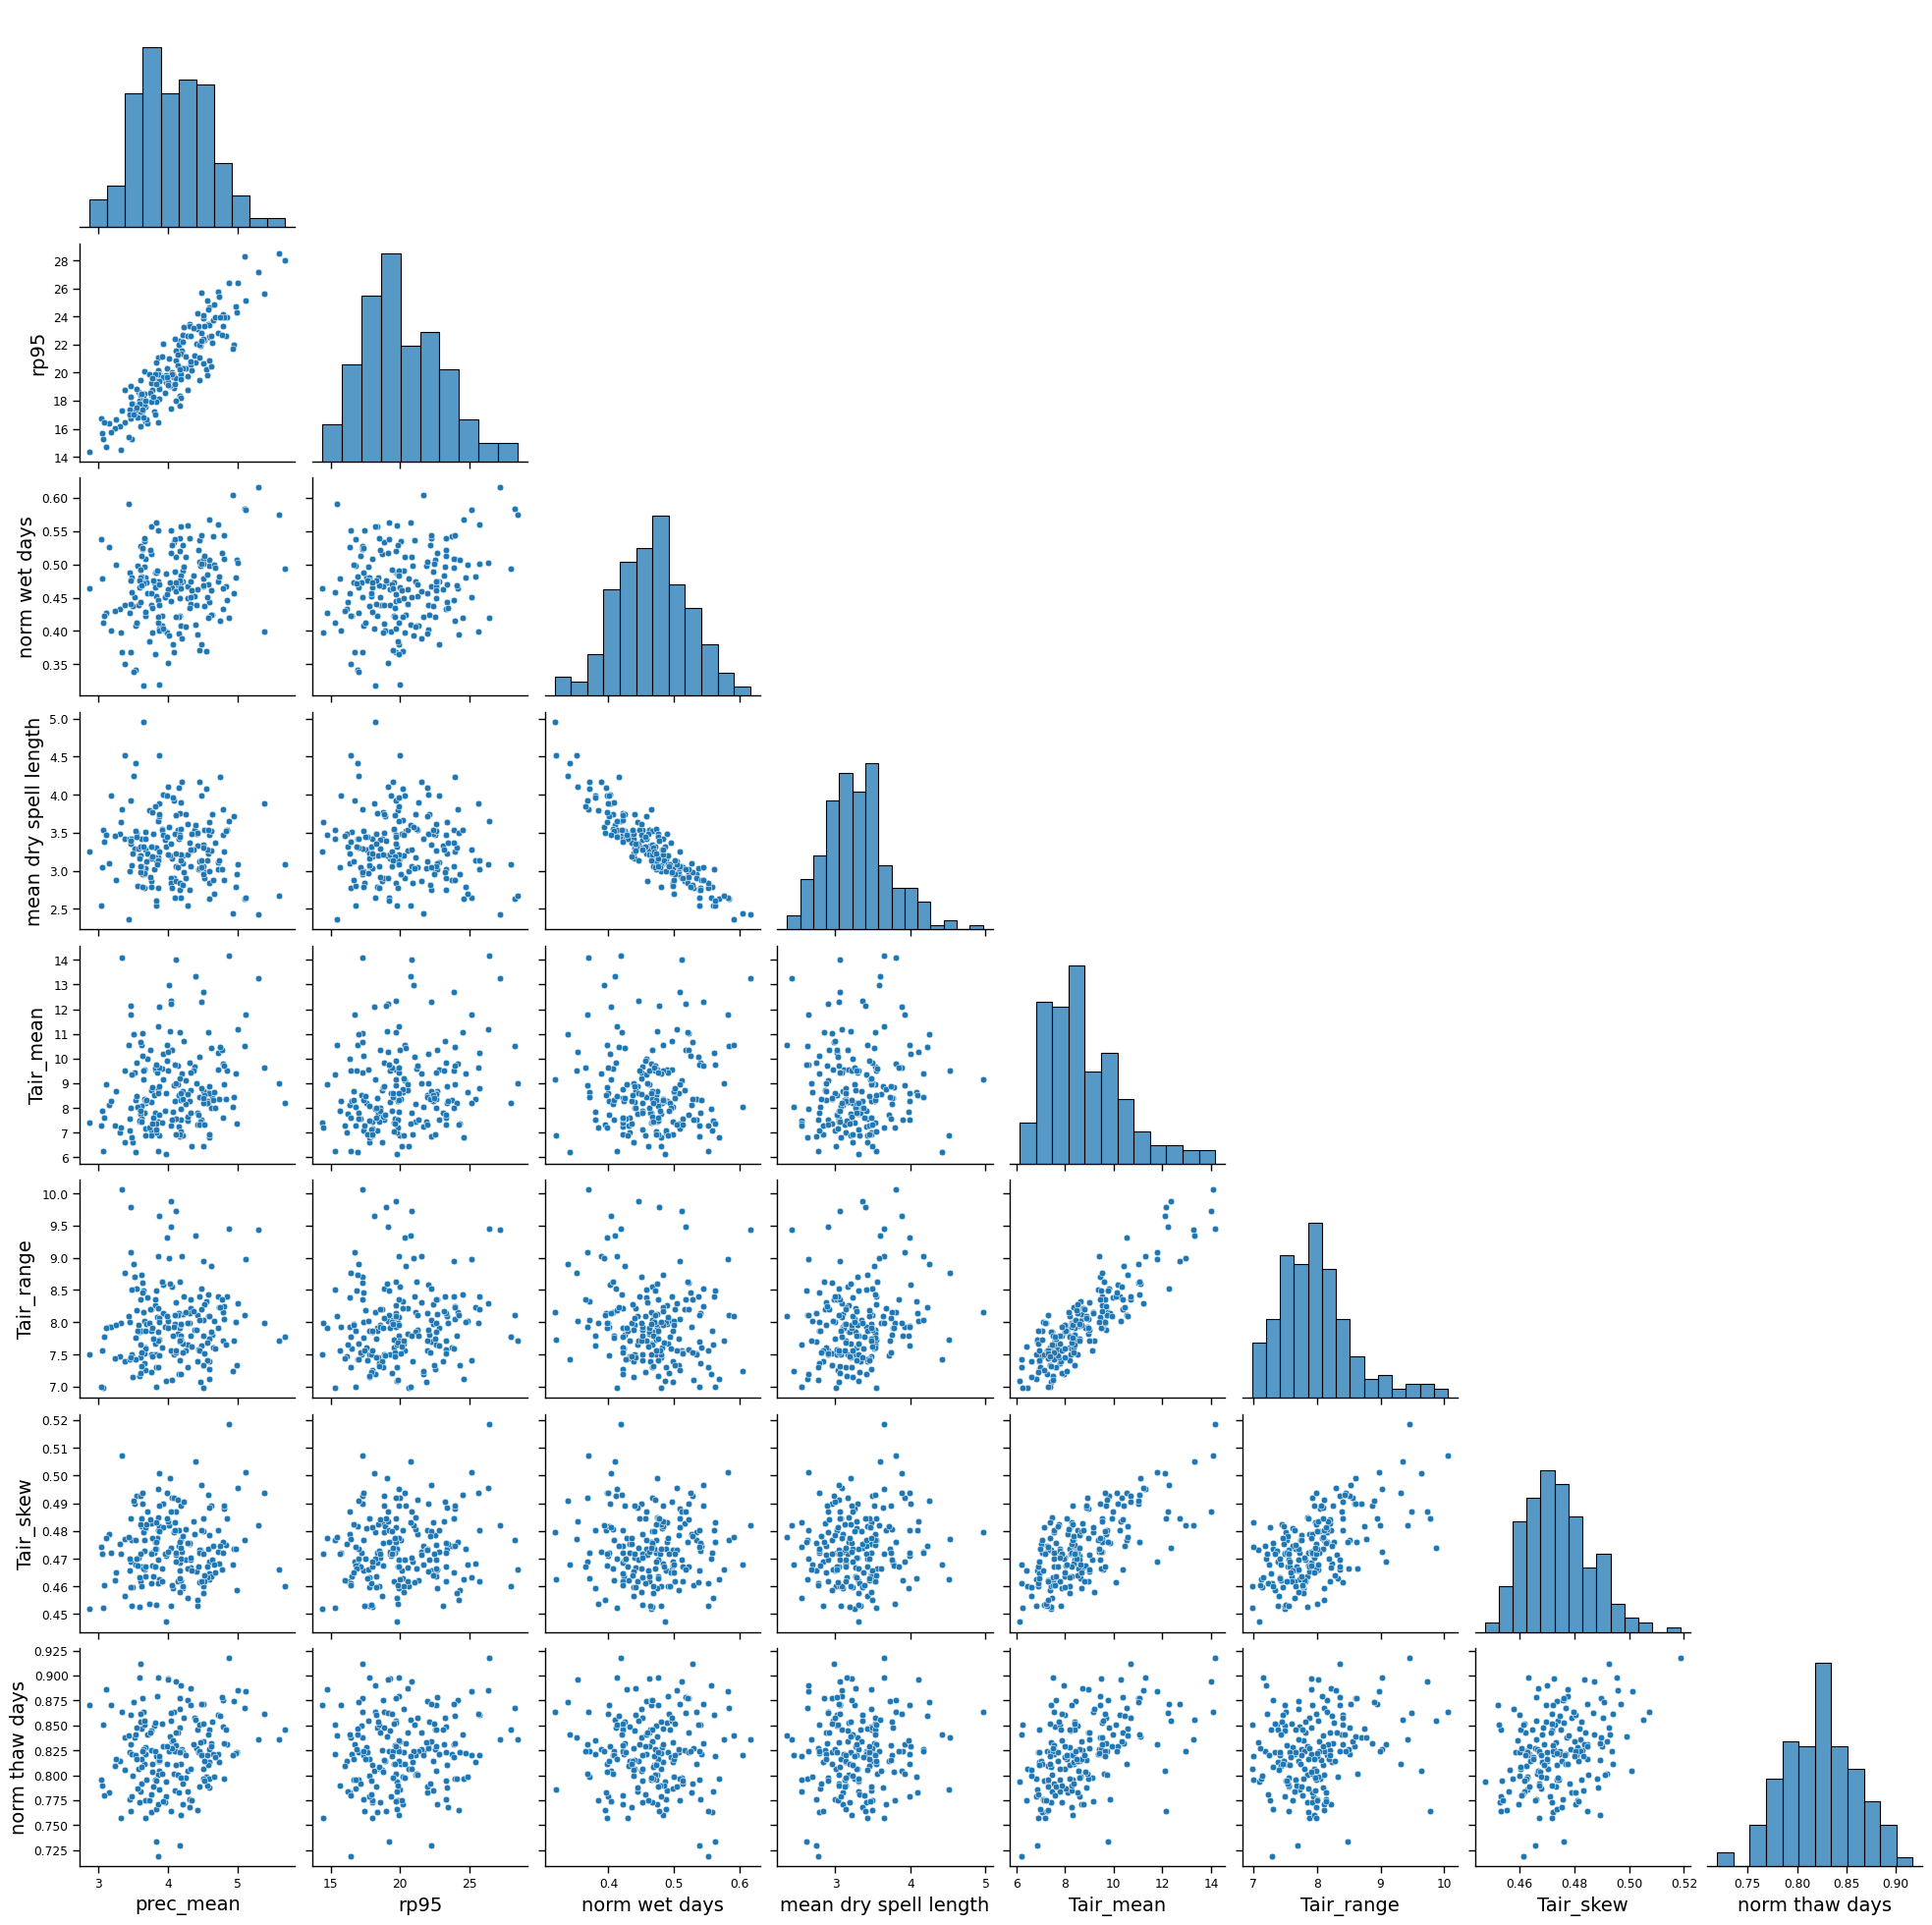

In [110]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
sns.pairplot(proposal_sims.dropna(), corner=True)
#plt.savefig("../plots/wgen_summary_stats_corner_plot.png")

In [46]:
# compute empirical mean and covariance, dropping rows with nan values
svi_posterior_sims_mean = torch.mean(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:], dim=0)
svi_proposal_sims_mean = torch.mean(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:], dim=0)
svi_posterior_sims_cov = torch.cov(svi_posterior_sims[torch.isfinite(svi_posterior_sims).all(dim=1),:].T)
svi_proposal_sims_cov = torch.cov(svi_proposal_sims[torch.isfinite(svi_proposal_sims).all(dim=1),:].T)

<Axes: >

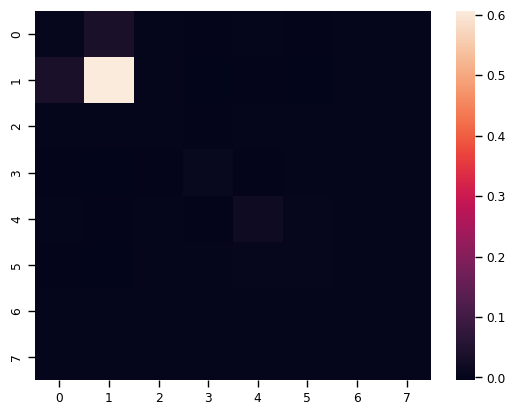

In [47]:
sns.heatmap(svi_posterior_sims_cov.numpy())

<Axes: >

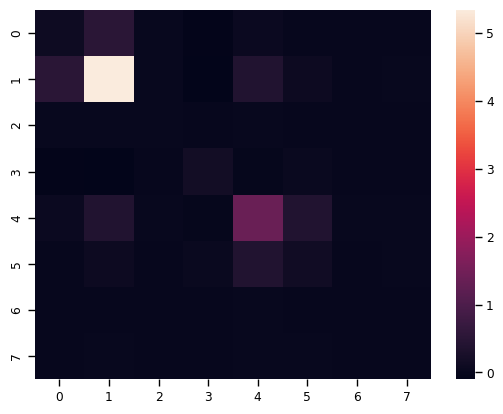

In [48]:
sns.heatmap(svi_proposal_sims_cov.numpy())

In [49]:
proposal_sims_dist = torch.distributions.MultivariateNormal(svi_proposal_sims_mean, svi_proposal_sims_cov)
obs_stats2 = t2j(proposal_sims_dist.sample((1,)).T)
obs_stats2 - obs_stats

Array([[-2.0868897e-01],
       [-2.3722725e+00],
       [ 1.8947244e-02],
       [-1.4467025e-01],
       [-1.0982389e+00],
       [-7.6457119e-01],
       [-5.2743554e-03],
       [ 2.3602247e-03]], dtype=float32)

In [ ]:
num_simulations = 2000
num_rounds = 1 # for some reason, single round inference seems to work much better than multi-round. might need to report this to the sbi developers?
proposal = svi_proposal
sbi_alg = SNPE(proposal)
# sbi_alg = SNLE(proposal)

In [ ]:
for i in range(num_rounds):
    print(f"Starting SBI round {i+1}/{num_rounds}")
    theta, x = simulate_for_sbi(wgen_sbi, proposal=proposal, num_simulations=num_simulations, simulation_batch_size=200)
    sbi_alg.append_simulations(theta, x, proposal, exclude_invalid_x=True)
    density_estimator = sbi_alg.train()
    sbi_posterior = sbi_alg.build_posterior(density_estimator).set_default_x(j2t(obs_stats.squeeze()))
    proposal = sbi_posterior
    print("")

In [ ]:
# sample from SBI posterior
sbi_samples = sbi_posterior.sample((200,))
sbi_posterior_sims = wgen_sbi(sbi_samples)

In [ ]:
# sample from recalibrated SBI posterior
obs_target = obs_stats2
sbi_samples2 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_posterior_sims2 = wgen_sbi(sbi_samples2)

In [ ]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8, label="SVI posterior")
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7, label="SBI prior")
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6, label="SBI posterior")
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims2.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3, label="SBI posterior (recalibrated)")
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_all_recalibrated.png")
plt.show()

In [55]:
sbi_posterior_sims2_shift = t2j(sbi_posterior_sims2.mean(axis=0))
sbi_posterior_sims2_scale = t2j(sbi_posterior_sims2.std(axis=0))
sbi_posterior_sims2_standardized = (t2j(sbi_posterior_sims2) - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid = sbi_posterior_sims2_standardized - (obs_target.T - sbi_posterior_sims2_shift) / sbi_posterior_sims2_scale
posterior_obs_resid.shape

(200, 8)

(array([ 2.,  7., 24., 39., 60., 33., 20., 12.,  2.,  1.]),
 array([-2.96089768, -2.32558632, -1.69027519, -1.05496395, -0.4196527 ,
         0.21565843,  0.85096979,  1.48628116,  2.12159228,  2.75690341,
         3.39221454]),
 <BarContainer object of 10 artists>)

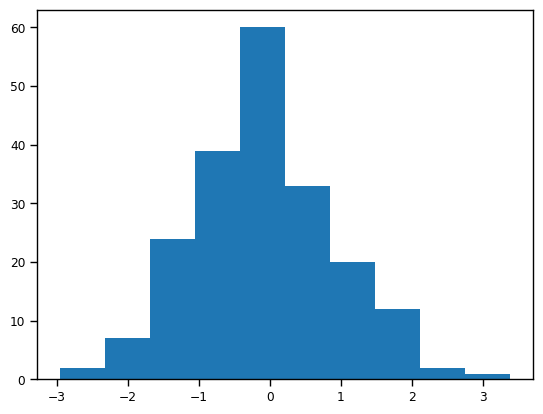

In [56]:
plt.hist(posterior_obs_resid[:,0])

In [57]:
summary_stats_df = basin_data_train[["prec","Tair_min","Tair_mean","Tair_max"]].groupby(basin_data_train.index.year).apply(lambda df: pd.DataFrame(wgen_summary_stats(df.index.values, df.prec.values, df.Tair_min.values, df.Tair_mean.values, df.Tair_max.values).reshape((1,-1)), columns=summary_stat_names)).reset_index().drop("level_1", axis=1)
summary_stats_df.describe()

,time,prec_mean,rp95,norm wet days,mean dry spell length,Tair_mean,Tair_range,Tair_skew,norm thaw days
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,1970.000000,1.841034,19.146120,0.464165,3.295445,8.464806,7.665947,0.483585,0.852496
std,11.979149,0.353711,4.528127,0.048617,0.514934,0.769984,0.580928,0.026299,0.049317
min,1950.000000,1.057300,13.098458,0.372603,2.553846,6.581241,6.549250,0.447778,0.753425
25%,1960.000000,1.523839,15.737223,0.427397,2.885246,7.802209,7.438528,0.464979,0.816940
50%,1970.000000,1.854292,18.018492,0.476712,3.216667,8.450788,7.685133,0.475402,0.852055
75%,1980.000000,2.098828,21.663124,0.498630,3.649123,9.033152,8.031537,0.493390,0.887671
max,1990.000000,2.655576,28.655827,0.546448,4.571429,10.052711,9.160261,0.537237,0.972603


In [58]:
obs_stats3 = obs_stats.at[1].add(5.0).at[2].add(-0.1).at[3].add(0.5)
obs_stats3 - obs_stats

Array([[ 0.        ],
       [ 5.        ],
       [-0.09999999],
       [ 0.5       ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]], dtype=float32)

In [59]:
# sample from recalibrated SBI posterior
obs_target = obs_stats3
sbi_samples3 = sbi_posterior.sample((200,), x=j2t(obs_target[:,0]))
sbi_samples3_mean = torch.quantile(sbi_samples3, q=0.5, axis=0, keepdims=True)*torch.ones((200,1))
sbi_posterior_sims3 = wgen_sbi(sbi_samples3_mean)

Drawing 200 posterior samples:   0%|          | 0/200 [00:00<?, ?it/s]

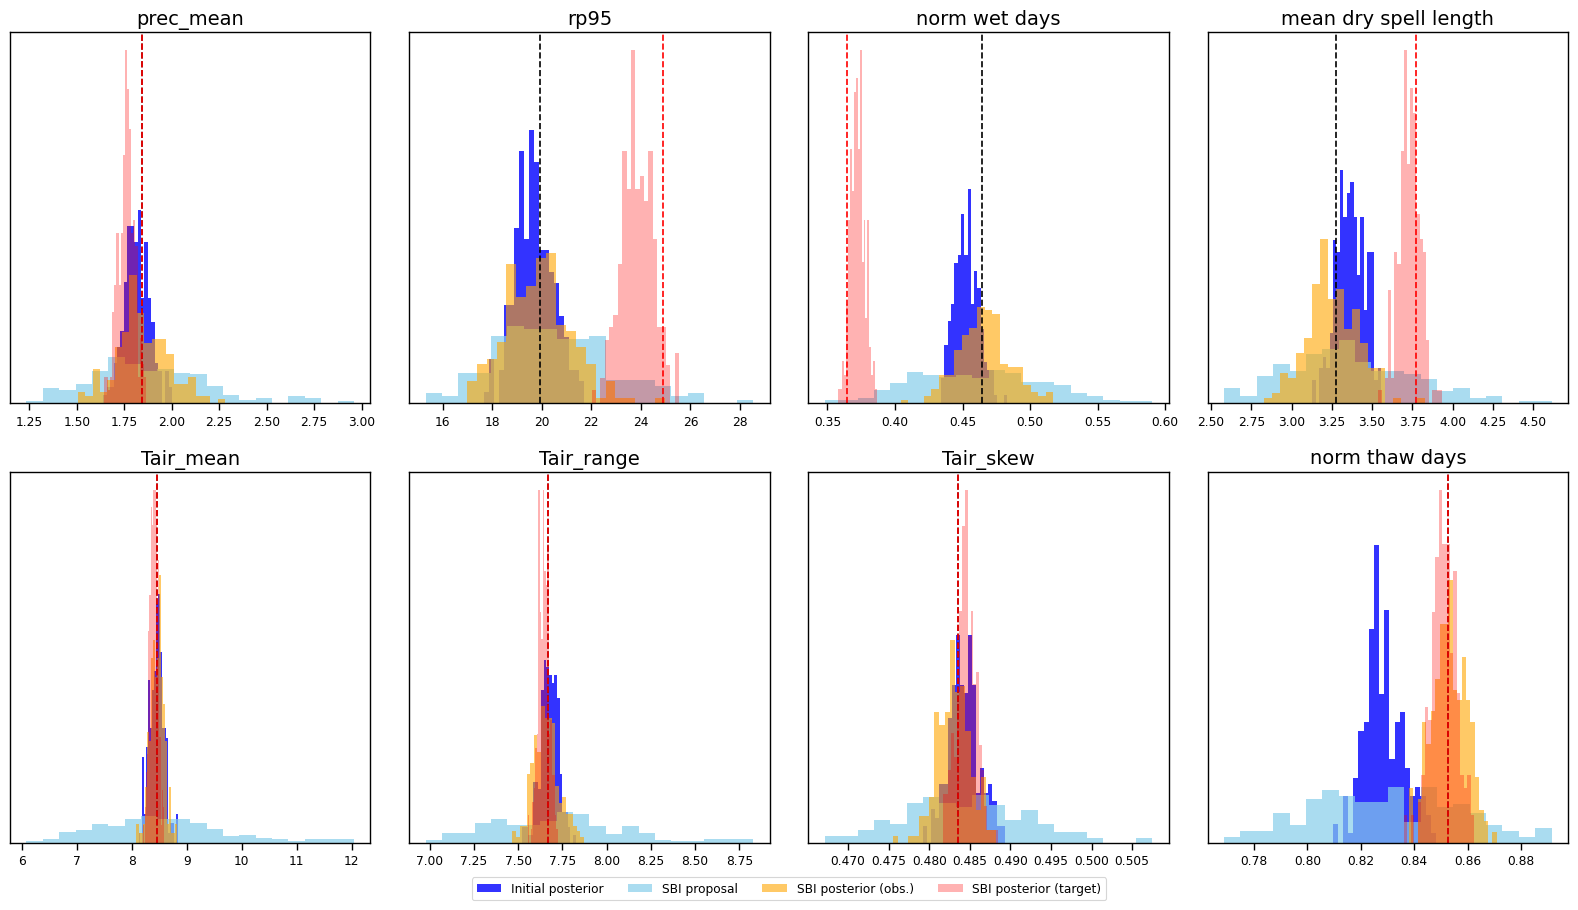

In [60]:
ncols = 4
nrows = 2
fig, axs = plt.subplots(nrows,ncols,figsize=(16,9))
for i in range(obs_stats.shape[0]):
    c = i % ncols
    r = i // ncols
    _,_,h1 = axs[r,c].hist(svi_posterior_sims.numpy()[:,i], bins=20, density=True, color='blue', alpha=0.8)
    _,_,h2 = axs[r,c].hist(svi_proposal_sims.numpy()[:,i], bins=20, density=True, color='skyblue', alpha=0.7)
    _,_,h3 = axs[r,c].hist(sbi_posterior_sims.numpy()[:,i], bins=20, density=True, color='orange', alpha=0.6)
    _,_,h4 = axs[r,c].hist(sbi_posterior_sims3.numpy()[:,i], bins=20, density=True, color='red', alpha=0.3)
    axs[r,c].axvline([obs_stats[i,:]], c='black', linestyle="--")
    axs[r,c].axvline([obs_target[i,:]], c='red', linestyle="--")
    axs[r,c].set_yticks([])
    axs[r,c].set_title(summary_stat_names[i])
for i in range(obs_stats.shape[0], ncols*nrows):
    c = i % ncols
    r = i // ncols
    fig.delaxes(axs[r,c])
labels = ["Initial posterior", "SBI proposal", "SBI posterior (obs.)", "SBI posterior (target)"]
fig.legend(handles=[h1,h2,h3,h4], labels=labels, ncol=4, loc="lower center", bbox_to_anchor=(0.5,-0.02))
plt.tight_layout()
plt.savefig("../plots/basin_6340800_sbi_posterior_rp95_wd_cdd_recalibrated.png")
plt.show()

In [61]:
sbi_posterior_samples_mean = sbi_samples.mean(axis=0, keepdims=True)
sbi_posterior_sims_mean = wgen_sbi(sbi_posterior_samples_mean)
sbi_posterior_sims_mean

tensor([[ 1.8457, 19.1253,  0.4719,  3.1900,  8.3043,  7.6414,  0.4813,  0.8474]])

In [62]:
sbi_params1 = wgen_prior.constrain(t2j(sbi_samples), as_dict=True)
sbi_params2 = wgen_prior.constrain(t2j(sbi_samples2), as_dict=True)
sbi_params3 = wgen_prior.constrain(t2j(sbi_samples3), as_dict=True)

In [63]:
sbi_predictive1 = Predictive(wgen.simulate, posterior_samples=sbi_params1, parallel=True)
sbi_preds1 = sbi_predictive1(prng)

In [64]:
sbi_predictive2 = Predictive(wgen.simulate, posterior_samples=sbi_params2, parallel=True)
sbi_preds2 = sbi_predictive2(prng)

In [65]:
sbi_predictive3 = Predictive(wgen.simulate, posterior_samples=sbi_params3, parallel=True)
sbi_preds3 = sbi_predictive3(prng)

In [66]:
sbi_preds1["Tavg"].shape

(200, 14975, 1)

In [67]:
wgen.obs['Tavg'].shape

(1, 14975)

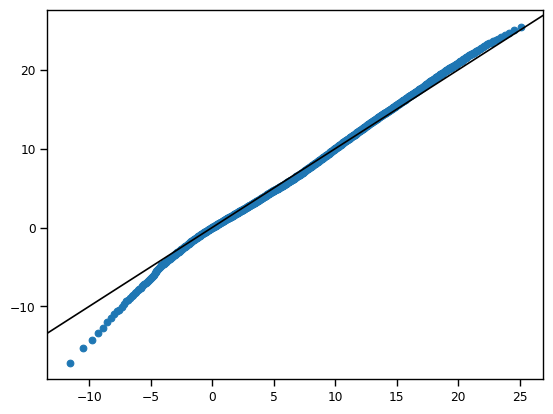

In [68]:
Tavg_preds1 = sbi_preds1["Tavg"].flatten().sort()
Tavg_obs1 = wgen.obs["Tavg"].squeeze().sort()
plt.scatter(np.quantile(Tavg_preds1, np.arange(0.001,0.999,0.001)), np.quantile(Tavg_obs1, np.arange(0.001,0.999,0.001)))
plt.axline((0,0),slope=1,color="black")

In [69]:
import xarray as xr

def to_xarray(data, preds):
    timestamps = data.index
    Tavg_sims = xr.DataArray(preds["Tavg"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tavg_sim")
    Tmin_sims = xr.DataArray(preds["Tmin"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmin_sim")
    Tmax_sims = xr.DataArray(preds["Tmax"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="Tmax_sim")
    prec_sims = xr.DataArray(preds["prec"].squeeze(), dims=("sample","time"), coords={"time": timestamps.values}, name="prec_sim")
    obs = data.to_xarray().astype(np.float32)
    return xr.merge([Tavg_sims, Tmin_sims, Tmax_sims, prec_sims, obs])

In [70]:
sbi_sims1_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds1)
sbi_sims2_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds2)
sbi_sims3_arr = to_xarray(basin_data_train[["Tair_mean","Tair_min","Tair_max","prec"]].iloc[wgen.first_valid_idx:,:], sbi_preds3)

In [72]:
sbi_sims1_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_obs_stats.nc")
sbi_sims2_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_rand_stats.nc")
sbi_sims3_arr.to_netcdf("../data/products/wgen_glm_v3_basin=6340800_sbi_tuned_stats.nc")

In [73]:
sbi_sims1_arr

<xarray.Dataset> Size: 48MB
Dimensions:    (time: 14975, sample: 200)
Coordinates:
  * time       (time) datetime64[ns] 120kB 1950-01-01 1950-01-02 ... 1990-12-31
Dimensions without coordinates: sample
Data variables:
    Tavg_sim   (sample, time) float32 12MB 2.318 3.241 2.972 ... 0.9073 -0.04229
    Tmin_sim   (sample, time) float32 12MB -4.668 1.906 ... -0.1766 -1.746
    Tmax_sim   (sample, time) float32 12MB 9.926 5.33 5.359 ... 2.711 3.549
    prec_sim   (sample, time) float32 12MB 0.0 0.0 5.898 4.239 ... 0.0 0.0 0.0
    Tair_mean  (time) float32 60kB -4.592 -0.241 1.185 ... 4.872 5.884 4.019
    Tair_min   (time) float32 60kB -5.684 -5.416 -0.2187 ... 0.4121 3.41 1.914
    Tair_max   (time) float32 60kB -2.228 0.9776 2.022 ... 6.171 9.602 6.355
    prec       (time) float32 60kB 0.0 14.84 3.41 2.306 ... 0.0 4.842 0.0 2.197